<a href="https://colab.research.google.com/github/Hernanros/Ames-house-pricing/blob/master/full%20notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pre-requisits

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
% cd /content/drive/My Drive/Mia schrieber

/content/drive/My Drive/Mia schrieber


In [7]:
! pip install datefinder

In [0]:
% matplotlib inline 

import pandas as pd
pd.options.display.max_columns = 150
pd.options.display.max_rows = 100
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import os
import glob
import datetime as dt
import datefinder
from dateutil import parser

from collections import defaultdict

import spacy
nlp = spacy.load("en_core_web_sm")
from spacy import lemmatizer

import nltk
from nltk.stem.porter import *


# File pre-proceesing
this part is the code used to load the files and produce a initial dataset

In [0]:
def file_parser(txtpath,w2i,i2w,search_filter=True):
    """
    
    Parameters
    ----------
    txtpath : string
        name of folder with different datafiles.
    Returns
    -------
    Pandas DataFrame
        data frame containing 4 columns: original text entry, publication, date and headline.
    
    
    
    Automated process to:
        1. open each text file, add it to a growing list of text files.
        2. create a unified word corpus  
        3. seperate to entries by pattern of 2 cosecutive newline charechters (\n)
        4. seperate each entry by pattern of 2 consecutive newline charechters (\n) and a digit right afterwards to sperate index and text
         
        5. extract name of publication from meta_data
        6. remove from each entry empty lines
        7. delete neline chars and puvlication name
        8. append to runnin list of indices and text
        9. create a datafram, extract the publication feature from the meta data
        10. look for date patterns in the text where they exist, create a new column containing date information
        11. interpolate missing date data 
        12. create a column of clean text containing the headline text without all of extra information
        13. concatenate to the existing dataframe
        14. concatenate to the existing dataframe
        
    """
    
    def intransletor(text,w2i):
        '''
        
        Parameters
        ----------
        text : string
            headline
        w2i : dict
            dictionary contating int values for each word in the keywords list.
        search_filter: bool
            toggle wehther to apply filtering for words in searchlist
    
        Returns
        -------
        list
            sentence as a sequence of ints.
        '''
        return [w2i[word] if word in set(w2i.keys()) else 999999 for word in text.split(' ')]

    def stringtranslator(numlist,i2w,oov):
        """
        return meaningful words from search list for list of numbers
    
        Parameters
        ----------
        numlist : list
            translated text entry
        i2w : dictionary
            dictionary of numbers to words
        oov : int
            token that represent unknown words
    
        Returns
        -------
        list of words from vocabulary
    
        """
        return [i2w[num] for num in numlist if num != oov ]
    
    def find_searchwords(df,text_col,w2i):
        '''
        Parameters
        ----------
        df : Pandas DataFrame
        text_col : string
            column that contains the data that will be edited
        w2i : dictionary
            dictionary contating int values for each word in the keywords list.
        Returns
        -------
        DataFrame
            Dataframe filtered for rows contining words from searchlist.
        '''
        
        df['number_list']=df[text_col].apply(lambda x: intransletor(x,w2i))
        has_word=df.number_list.apply(lambda x:pd.Series(x).nunique()>1)
        return df[has_word]
   
    def dayfinder(date):
        
        num=date.weekday()
        dayname = calendar.day_name[num].lower()
        return dayname 

        
    def date_cleaner(text,split_marker,pattern=None):
        '''
        Parameters
        ----------
        text : string
            the text to parse through.
        split_marker : string
            name of publication or other token that sepreate headline from other data.
        pattern : string, optional
            A regex pattern to find dates in the text. The default is a predefined pattern.
        Returns
        -------
        string
            headline only in lowercase
        '''
        
        
        if pattern==None:
           pattern=r'(\b[A-Z]?[a-z]+\s\d{1,2}\,\s\d{2,4})'
        if split_marker=='The Washington Post':
               split_marker= r'(The Washington Post)|(Washington Post Blogs)|(Washingtonpost)' 
        elif split_marker=="The Guardian(London)":
            split_marker=r"(The Guardian)|(Guardian.com)"
        elif split_marker=='The Daily Telegraph (London)':
            split_marker='The Daily Telegraph'
         
        text= re.sub(split_marker.lower(),'@#$%^',text.lower()).strip('. ')
        text=re.sub(r'\s{2,}',' ',text)
        split_date=text.lower().split('@#$%^') 
        cleaned=[]
        if len(split_date)>1:
            for side in split_date:
                if len(re.findall(pattern,side))==0:
                    cleaned+=side      
            
        return ''.join(cleaned)
            
  



    # 1. open each text file, add it to a growing list of text files.
    pbar=tqdm(total=len(os.listdir(txtpath)),position=0, leave=True)
    file_num=0
    for filename in glob.glob(os.path.join(txtpath, '*.txt')):
        with open(os.path.join('', filename), 'rt',encoding="utf-8") as f:
            full=f.readlines()
            txt_list=[]
            ind_list=[]
            lst=[]
            
            # 2. create a unified word corpus  
            corp='\n'.join(full)
            errors=[]

            # 3. seperate to entries by pattern of 2 cosecutive newline charechters (\n)
            try:
                meta,result=corp.split('\n\n    Results')
            except:
                errors.append(filename)
           #     continue
            
            #clean the text

            # 4. seperate each entry by pattern of 2 consecutive newline charechters (\n) and a digit right afterwards to sperate index and text
            pat=r'(\n\n\b\d+)'
            tmplst=re.split(pat,result)

            # 5 . extract name of publication from meta_data
            pub=meta.split('Source: ')[1].split('\n')[0]            
            
            
            # 6. remove from each entry the empty lines.
            # 7. delete newline chars, publication name            
            
            for line in tmplst:
                if line is not None:
                    if len(line)>0: 
                        lst.append(re.sub('\n','',line))

            # 8. append to runnin list of indices and text
        
        
            
            txt_list=txt_list+lst[1::2]
            ind_list=ind_list+lst[::2]
            
            # 9. create a dataframe, extract the publication feature from the meta data
            df=pd.DataFrame(pd.Series(txt_list,name='text'))
            #df['cleaned_text']=df['text'].apply(lambda x: re.sub(pub.lower(),'',x.lower()))
            df['publication']=pub
                 
            # 10. look for date patterns in the text where they exist, create a new column containing date information
            date_pattern=r'(\b[A-Z][a-z]+\s\d{1,2}\,\s\d{2,4})'
            try:
                df['date']= df['text'].apply(lambda x: re.findall(date_pattern,x)[0])
                df['date']= df['date'].apply(lambda x:dt.datetime.strptime(x,"%B %d, %Y"))
            except:
                df['date']=None
            
            # 11. interpolate missing date data 
            df['date']= df['date'].fillna(method='pad')
            
            
            # 12. create a column of clean text containing the headline text without all of extra information
            df['cleaned_text']=df['text'].apply(lambda x:date_cleaner (x,pub))
            
            # 13. filter dataframe for values that contain one of the searchwords
            if search_filter:
                df=find_searchwords(df,'cleaned_text',w2i)
                df['searchwords_in_headline']=df.number_list.apply(lambda x:stringtranslator(x,i2w,999999))

    
    
            # 14. concatenate to the existing dataframe
            if file_num==0:
                headline=df
            else:
                headline=pd.concat([headline,df],axis=0)
            
            file_num+=1
            pbar.update()
    pbar.close()
    return headline
#%%

def intransletor(text,w2i):
    '''
    
    Parameters
    ----------
    text : string
        headline
    w2i : dict
        dictionary contating int values for each word in the keywords list.
    search_filter: bool
        toggle wehther to apply filtering for words in searchlist
    Returns
    -------
    list
        sentence as a sequence of ints.
    '''
    return [w2i[word] if word in set(w2i.keys()) else 999999 for word in text.split(' ')]

def stringtranslator(numlist,i2w,oov):
    """
    return meaningful words from search list for list of numbers
    Parameters
    ----------
    numlist : list
        translated text entry
    i2w : dictionary
        dictionary of numbers to words
    oov : int
        token that represent unknown words
    Returns
    -------
    list of words from vocabulary
    """
    return [i2w[num] for num in numlist if num != oov ]

In [10]:

path="python projects/Mia's Doctorat/"
txtpath="python projects/Mia's Doctorat/txtfiles/"
words=pd.read_excel(".\python projects\Mia's Doctorat\words.xlsx")
words.columns=['word']
word2i={word:i for i, word in enumerate(list(words['word']))}
i2word={i:word for i, word in enumerate(list(words['word']))}

'''
headline=file_parser(txtpath,word2i,False)
headline=pd.read_csv(".\python projects\Mia's Doctorat\headline1.csv",header=0)
filtered=file_parser(txtpath,word2i)


idxs=np.random.choice(headline.index,5000,False)
sample=filtered.iloc[idxs,:]

# remove empty headlines
total_lines=headline.shape[0]
headline=headline[headline.cleaned_text.notna()]
total_lines_noNA=headline.shape[0]

print ('total number of headlines: {},\t number after removing headlines with no content:{},\n difference:{}\t percentege valid:{}'.format(
    total_lines,total_lines_noNA,total_lines-total_lines_noNA,np.round(100*(total_lines_noNA/total_lines),2)))

filtered['number_list']=filtered.cleaned_text.apply(lambda x: intransletor(x,word2i))
filtered=filtered.drop('int',axis=1)
filtered['searchwords_in_headline']=filtered.number_list.apply(lambda x:stringtranslator(x,i2word,999999))

filtered.columns=['original_text','publication','date','headline','number_list','searchwords_in_headline']
filtered.to_csv('{}filtered_headlines.csv')
'''

FileNotFoundError: ignored

# Helper functions

In [0]:
# Helper functions
def random_examples(series, counter,num_random):
  for i in range(num_random):
    random_index=np.random.choice(series.index)
    print("Number of searchwords: {}\nHeadline:\n{}\n".format(counter[random_index],series[random_index]))

def intransletor(text,w2i):
    '''
    

    Parameters
    ----------
    text : string
        headline
    w2i : dict
        dictionary contating int values for each word in the keywords list.
    search_filter: bool
        toggle wehther to apply filtering for words in searchlist

    Returns
    -------
    list
        sentence as a sequence of ints.

    '''
    return [w2i[word] if word in set(w2i.keys()) else 999999 for word in text.split(' ')]

def stringtranslator(numlist,i2w,oov):
    """
    return meaningful words from search list for list of numbers

    Parameters
    ----------
    numlist : list
        translated text entry
    i2w : dictionary
        dictionary of numbers to words
    oov : int
        token that represent unknown words

    Returns
    -------
    list of words from vocabulary

    """
    return [i2w[num] for num in numlist if num != oov ]

def find_searchwords(df,text_col,w2i):
    '''

    Parameters
    ----------
    df : Pandas DataFrame
    text_col : string
        column that contains the data that will be edited
    w2i : dictionary
        dictionary contating int values for each word in the keywords list.

    Returns
    -------
    DataFrame
        Dataframe filtered for rows contining words from searchlist.

    '''
    
    df['number_list']=df[text_col].apply(lambda x: intransletor(x,w2i))
    has_word=df.number_list.apply(lambda x:pd.Series(x).nunique()>1)
    return df[has_word]

def find_searchwords(df,text_col,w2i):
    '''

    Parameters
    ----------
    df : Pandas DataFrame
    text_col : string
        column that contains the data that will be edited
    w2i : dictionary
        dictionary contating int values for each word in the keywords list.

    Returns
    -------
    DataFrame
        Dataframe filtered for rows contining words from searchlist.

    '''
    
    df['number_list']=df[text_col].apply(lambda x: intransletor(x,w2i))
    has_word=df.number_list.apply(lambda x:pd.Series(x).nunique()>1)
    return df[has_word]

def dayfinder(date):
    
    num=date.weekday()
    dayname = calendar.day_name[num].lower()
    return dayname 

    
def date_cleaner(text,split_marker,pattern=None):
    '''
    Parameters
    ----------
    text : string
        the text to parse through.
    split_marker : string
        name of publication or other token that sepreate headline from other data.
    pattern : string, optional
        A regex pattern to find dates in the text. The default is a predefined pattern.

    Returns
    -------
    string
        headline only in lowercase

    '''
    if pattern==None:
        pattern=r'(\b[A-Z]?[a-z]+\s\d{1,2}\,\s\d{2,4})'
    if split_marker=='The Washington Post':
          split_marker= r'(The Washington Post)|(Washington Post Blogs)|(Washingtonpost)' 
    elif split_marker=="The Guardian(London)":
      split_marker=r"(The Guardian)|(Guardian.com)"
    elif split_marker=='The Daily Telegraph (London)':
      split_marker='The Daily Telegraph'

    text= re.sub(split_marker.lower(),'@#$%^',text.lower()).strip('. ')
    text=re.sub(r'\s{2,}',' ',text)
    split_date=text.lower().split('@#$%^') 
    cleaned=[]
    if len(split_date)>1:
      for side in split_date:
          if len(re.findall(pattern,side))==0:
              cleaned+=side      
      
    return ''.join(cleaned)

def space_eraser(sample):
  for word in sample:
    re.sub(' ','',word)
  return sample

def pos_translation(sentence,schlist):
  doc = nlp(sentence)
  return[word.pos_ for word in doc if str(word) in schlist] 

def search_word_counter(sample_list,def_dict):
  for word in sample_list:
    def_dict[word]+=1

    

def search_pos_searchwords(sample,def_dic,search_col,pos_col):
  '''
  create a dictionary that counts for each token its appearences as different part of speech tags
    In : 
      - sample (dataframe)
      - def_dic (dictionary) - empty
      - searchwords_col - the columns that contains the searchwords to count
      - pos_col - column that contains the part of speach classification for the searchwords
    return:
      def dic (dictionary) : counts for pos appearences for each word
    '''
  word , pos = sample[search_col],  re.sub("\'|\[|\]| ",'',sample[pos_col]).split(',')
  for w,p in zip(word,pos):
    if w not in samp_dic.keys():
      samp_dic[w]=defaultdict(int)
    samp_dic[w][p]+=1

def sentiment_measure(sample,sent_dict,search_col):
  '''
  count sentiment related keywords in a headline
  IN:
    - sample: Seires or data entry line
    - sent_dict (dictionary) : sentiment translation for each word
    - search col : column with keywords to search in dictionary
  return:
    - (neg,neu,pos) tupple with counts for negative, neutral and positive searchwords in headline
    '''
  sentlist = [sent_dict[word] for word in sample[search_col] if word in list(sentiments_dict.keys())]
  neg,neu,pos=0,0,0
  for sent in sentlist:
    if sent == 'NEG':
      neg+=1
    elif sent == 'NEU':
      neu+=1
    elif sent == 'POS':
      pos+=1
  return neg,neu,pos

def date_zoom(df ,df_date,low,high):
  mask = (low < df_date) & (high > df_date)
  return df[mask]



# Data loading

In [12]:
headlines = pd.read_csv('headlines_with_lemma.csv')

headlines.searchwords_in_headline=headlines.searchwords_in_headline.apply(lambda x: eval(x))
headlines.searchwords_in_headline=headlines.searchwords_in_headline.apply(lambda x: space_eraser(x))

headlines.head()

Unnamed: 0  Unnamed: 0.1  \
0           0             8   
1           1            11   
2           2            14   
3           3            16   
4           4            33   

                                                text  \
0  .  New year, new voices;  BOOKS Orlando Bird p...   
1  . News broadcasts: the best reporting podcasts...   
2  . The ascent of household brand Everest;  The ...   
3  . City plan to pull the plug on Klopp's heavy ...   
4  . Cause of pop star's death still unknown amid...   

                    publication        date  \
0  The Daily Telegraph (London)  2016-12-31   
1  The Daily Telegraph (London)  2016-12-31   
2  The Daily Telegraph (London)  2016-12-31   
3  The Daily Telegraph (London)  2016-12-31   
4  The Daily Telegraph (London)  2016-12-31   

                                        cleaned_text  \
0  new year, new voices; books orlando bird picks...   
1      news broadcasts: the best reporting podcasts    
2  the ascent of household brand everest; the hom...   
3  city plan to pull the plug on klopp's heavy me...   
4  cause of pop star's death still unknown amid h...   

                                         number_list searchwords_in_headline  \
0  [999999, 999999, 999999, 999999, 107, 999999, ...                 [books]   
1  [999999, 999999, 999999, 999999, 722, 999999, ...             [reporting]   
2  [999999, 999999, 999999, 999999, 999999, 99999...                [thanks]   
3  [999999, 999999, 999999, 999999, 999999, 99999...                [warned]   
4  [999999, 999999, 999999, 999999, 999999, 99999...                [claims]   

  lemmatized_searchwords stemmed_searchwords   pos_searchwords  
0               ['book']            ['book']          ['NOUN']  
1          ['reporting']          ['report']          ['NOUN']  
2              ['thank']           ['thank']  ['NOUN', 'NOUN']  
3               ['warn']            ['warn']          ['VERB']  
4              ['claim']           ['claim']          ['NOUN']

In [13]:
words=pd.read_excel("words.xlsx")
words.columns=['word']
word2i={word:i for i, word in enumerate(list(words['word']))}
i2word={i:word for i, word in enumerate(list(words['word']))}
words

word
0        order
1       orders
2      ordered
3     ordering
4      command
..         ...
871  resolving
872     decide
873    decided
874    decides
875   deciding

[876 rows x 1 columns]

In [0]:
to_omit=pd.read_excel('OMIT.xlsx',header=None)
sentiments_dict=pd.read_excel('classification.xlsx',header=None)

sentiments_dict = dict(zip(sentiments_dict[0].apply(lambda x: re.sub(' ','',str(x)))
,sentiments_dict[1].apply(lambda x: re.sub(' ','',str(x)))))

In [0]:
hlines=pd.read_csv('hlines_stem_pos.csv')

# Searchword Frequency Analysis

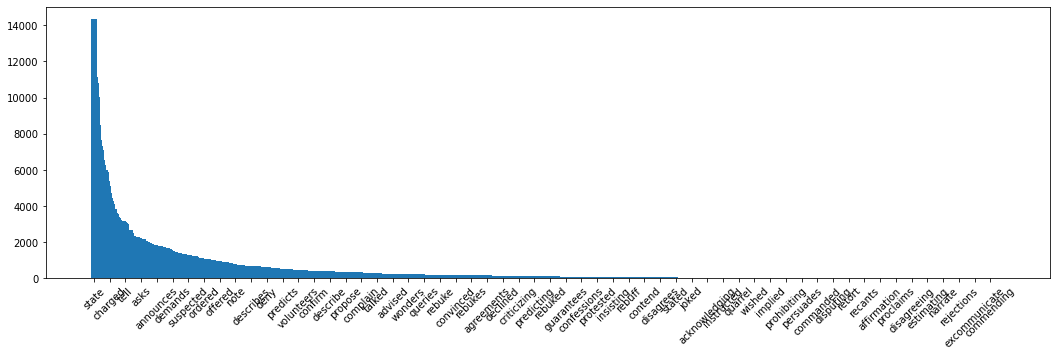

In [16]:
search_counts=defaultdict(int)

headlines.searchwords_in_headline.apply(lambda x: search_word_counter(x,search_counts))
search_counts=pd.Series(search_counts,name='counts')

f, ax = plt.subplots(figsize=(18,5))
plt.bar(search_counts.sort_values(ascending=False).keys(),search_counts.sort_values(ascending=False),width=5);
plt.xticks([key for i, key in enumerate(search_counts.sort_values(ascending=False).keys()) if (i+15)%15==0],rotation=45);

In [17]:
pd.options.display.max_rows = 999
search_counts.sort_index()
#search_counts.sort_index()

absolve                7
absolved               9
absolves               7
absolving              5
abuse               3574
abused               389
abuses               346
abusing              246
accept               894
acceptance           199
accepted             223
accepting            217
accepts              330
accuse               512
accused             6549
accuses             1894
accusing             195
acknowledge          141
acknowledged          71
acknowledges         249
acknowledging         37
acknowledgment        10
acknowledgments        4
acquit                 9
acquits               40
acquittal             72
acquittals             9
acquitted            212
add                 1343
added                501
adding               422
adds                1264
admit                568
admits              2213
admitted             306
admitting            147
admonish               3
admonished            10
admonishes            16
admonishing            2


We can clearly see that the numbers are a bit misleading, since a LOT of words frequencies are divided between the different pronunciations of the keyword. <br>
We will need to do some worda normalization, we are going to try NLTK's stemming

In [18]:
pd.options.display.max_rows = 50

stemmer = PorterStemmer()


searchwords=list(search_counts.sort_index().index)
doc=nlp(' '.join(searchwords))

lemmatized=pd.Series([word.lemma_ for word in doc],name='lemmatized_word',index=searchwords)
stemmed=pd.Series([stemmer.stem(word) for word in searchwords],name='stemmed_word',index=searchwords)
print(" before lemmatization we had {} unique words, lematization leaves us with {} words, and stemming leaves us with {} unique words".format(len(list(searchwords)),lemmatized.nunique(),
                                                                                                                                               stemmed.nunique()))
normalized=pd.DataFrame((lemmatized,stemmed))

print('number of different words collapsed into same term:\n')
normalized.loc[:,'chlleneged':]

 before lemmatization we had 867 unique words, lematization leaves us with 325 words, and stemming leaves us with 229 unique words
number of different words collapsed into same term:



christen christened christening christens  claim claimed  \
lemmatized_word  christen   christen    christen  christen  claim   claim   
stemmed_word     christen   christen    christen  christen  claim   claim   

                claiming claims  command commanded commanding commands  \
lemmatized_word    claim  claim  command   command    command  command   
stemmed_word       claim  claim  command   command    command  command   

                 commend commended commending commends  comment commented  \
lemmatized_word  commend   commend    commend  commend  comment   comment   
stemmed_word     commend   commend    commend  commend  comment   comment   

                commenting comments  compare compared compares comparing  \
lemmatized_word    comment  comment  compare  compare  compare   compare   
stemmed_word       comment  comment   compar   compar   compar    compar   

                 complain complained complaining complains  complaint  \
lemmatized_word  complain   complain    complain  complain  complaint   
stemmed_word     complain   complain    complain  complain  complaint   

                complaints  compliment complimented compliments  concede  \
lemmatized_word  complaint  compliment   compliment  compliment  concede   
stemmed_word     complaint  compliment   compliment  compliment   conced   

                conceded concedes conceding  conclude concluded concludes  \
lemmatized_word  concede  concede   concede  conclude  conclude  conclude   
stemmed_word      conced   conced    conced   conclud   conclud   conclud   

                concluding  condemn  condemnation condemnations condemned  \
lemmatized_word   conclude  condemn  condemnation  condemnation   condemn   
stemmed_word       conclud  condemn       condemn       condemn   condemn   

                condemning condemns  confess confessed confesses confessing  \
lemmatized_word    condemn  condemn  confess   confess  confesse    confess   
stemmed_word       condemn  condemn  confess   confess   confess    confess   

                 confession confessions  confide confided  confirm  \
lemmatized_word  confession  confession  confide  confide  confirm   
stemmed_word        confess     confess   confid   confid  confirm   

                 confirmation confirmations confirmed confirming confirms  \
lemmatized_word  confirmation  confirmation   confirm    confirm  confirm   
stemmed_word          confirm       confirm   confirm    confirm  confirm   

                 congratulate congratulated congratulates congratulating  \
lemmatized_word  congratulate  congratulate  congratulate   congratulate   
stemmed_word        congratul     congratul     congratul      congratul   

                 conjecture  consent consented  consenting consents  consult  \
lemmatized_word  conjecture  consent   consent  consenting  consent  consult   
stemmed_word      conjectur  consent   consent     consent  consent  consult   

                 consultation consultations consulted consulting  ... summing  \
lemmatized_word  consultation  consultation   consult    consult  ...     sum   
stemmed_word          consult       consult   consult    consult  ...     sum   

                 summon summoned summons sums  suppose supposed supposes  \
lemmatized_word  summon   summon  summon  sum  suppose  suppose  suppose   
stemmed_word     summon   summon  summon  sum   suppos   suppos   suppos   

                 suspect suspected  suspecting suspects  swear swearing  \
lemmatized_word  suspect   suspect  suspecting  suspect  swear    swear   
stemmed_word     suspect   suspect     suspect  suspect  swear    swear   

                swears  swore  talk talked talking talks  tell  telling tells  \
lemmatized_word  swear  swear  talk   talk    talk  talk  tell  telling  tell   
stemmed_word     swear  swore  talk   talk    talk  talk  tell     tell  tell   

                testified testifies  testify testifying  thank thanked  \
lemmatized_word   te

In [19]:
lemma_dict=dict(zip(searchwords,lemmatized))
stem_dict=dict(zip(searchwords,stemmed))

headlines['lemmatized_searchwords']=headlines['searchwords_in_headline'].apply(lambda x: [lemma_dict[word] for word in x])
headlines['stemmed_searchwords']=headlines['searchwords_in_headline'].apply(lambda x: [stem_dict[word] for word in x])
headlines.head(15)

Unnamed: 0  Unnamed: 0.1  \
0            0             8   
1            1            11   
2            2            14   
3            3            16   
4            4            33   
5            5            34   
6            6            35   
7            7            45   
8            8            50   
9            9            51   
10          10            55   
11          11            58   
12          12            61   
13          13            62   
14          14            75   

                                                 text  \
0   .  New year, new voices;  BOOKS Orlando Bird p...   
1   . News broadcasts: the best reporting podcasts...   
2   . The ascent of household brand Everest;  The ...   
3   . City plan to pull the plug on Klopp's heavy ...   
4   . Cause of pop star's death still unknown amid...   
5   . The world is not ready for killer flu epidem...   
6   . How student who let slip Duke's China gaffe ...   
7   . Welcome to a very wet new year - but at leas...   
8   . Martin Schulz 'will not challenge Merkel at ...   
9   . Romania's president names prime minister;  W...   
10  . Vote on social care tax 'ploy by councils'  ...   
11  . Israel warns of India terror attack risk    ...   
12  . Who is Serena's 'luckiest nerd' fiancé?;  Hi...   
13  . Who is Serena's 'luckiest nerd' fiancé?;  FE...   
14  . Firms call for separate business rates in Lo...   

                     publication        date  \
0   The Daily Telegraph (London)  2016-12-31   
1   The Daily Telegraph (London)  2016-12-31   
2   The Daily Telegraph (London)  2016-12-31   
3   The Daily Telegraph (London)  2016-12-31   
4   The Daily Telegraph (London)  2016-12-31   
5   The Daily Telegraph (London)  2016-12-31   
6   The Daily Telegraph (London)  2016-12-31   
7   The Daily Telegraph (London)  2016-12-31   
8   The Daily Telegraph (London)  2016-12-31   
9   The Daily Telegraph (London)  2016-12-31   
10  The Daily Telegraph (London)  2016-12-31   
11  The Daily Telegraph (London)  2016-12-31   
12  The Daily Telegraph (London)  2016-12-31   
13  The Daily Telegraph (London)  2016-12-31   
14  The Daily Telegraph (London)  2016-12-31   

                                         cleaned_text  \
0   new year, new voices; books orlando bird picks...   
1       news broadcasts: the best reporting podcasts    
2   the ascent of household brand everest; the hom...   
3   city plan to pull the plug on klopp's heavy me...   
4   cause of pop star's death still unknown amid h...   
5   the world is not ready for killer flu epidemic...   
6   how student who let slip duke's china gaffe tr...   
7   welcome to a very wet new year - but at least ...   
8   martin schulz 'will not challenge merkel at po...   
9   romania's president names prime minister; worl...   
10        vote on social care tax 'ploy by councils'    
11          israel warns of india terror attack risk    
12  who is serena's 'luckiest nerd' fiancé?; his w...   
13  who is serena's 'luckiest nerd' fiancé?; featu...   
14  firms call for separate business rates in lond...   

                                          number_list searchwords_in_headline  \
0   [999999, 999999, 999999, 999999, 107, 999999, ...                 [books]   
1   [999999, 999999, 999999, 999999, 722, 999999, ...             [reporting]   
2   [999999, 999999, 999999, 999999, 999999, 99999...                [thanks]   
3   [999999, 999999, 999999, 999999, 999999, 99999...                [warned]   
4   [999999, 999999, 999999, 999999, 999999, 99999...                [claims]   
5   [999999, 999999, 999999, 999999, 999999, 99999...                 [warns]   
6   [999999, 999999, 999999, 999999, 999999, 99999...                  [joke]   
7   [488, 999999, 999999, 999999, 999999, 999999, ...               [welcome]   
8   [999999, 999999, 999999, 999999, 370, 999999, ...             [challenge]   
9   [999999, 999999, 627, 999999, 999999, 999999, ...                 [names]   
10  [

Now after we have created a normalized version of our words, let create a searchword count again.

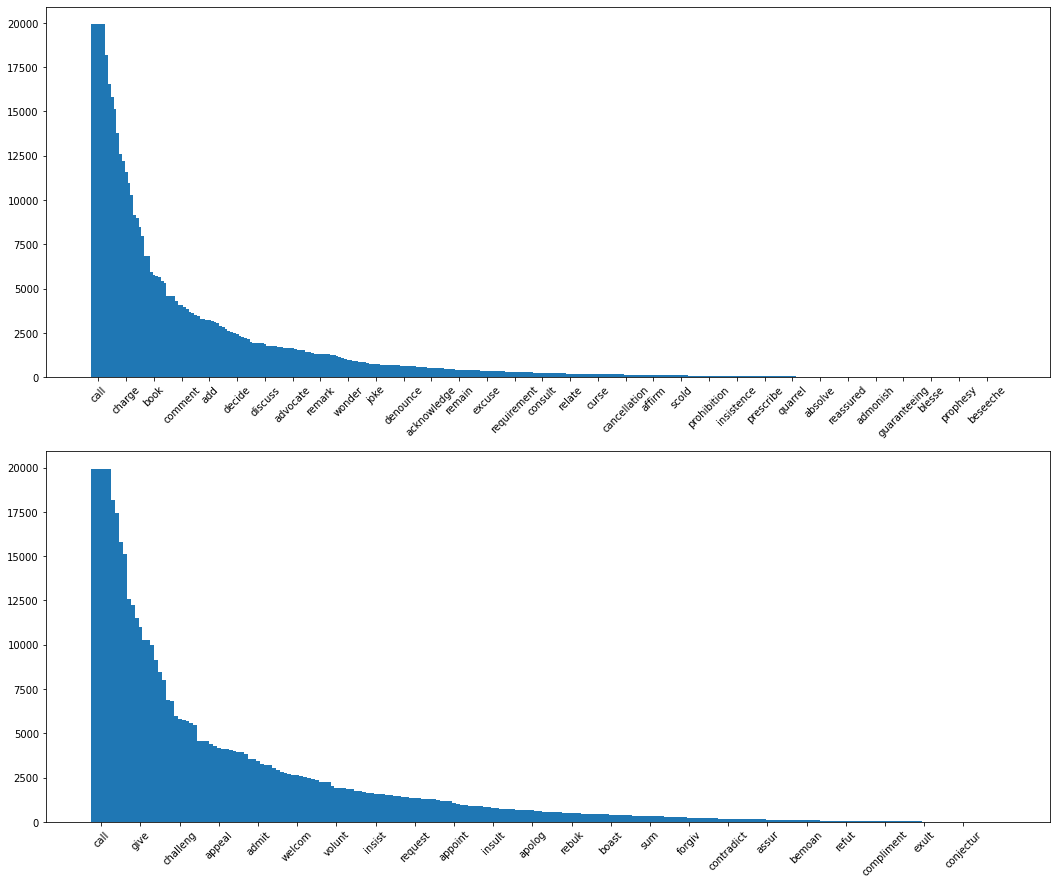

In [20]:
lemma_search_counts=defaultdict(int)

headlines.lemmatized_searchwords.apply(lambda x: search_word_counter(x,lemma_search_counts))
lemma_search_counts=pd.Series(lemma_search_counts,name='counts')

stem_search_counts=defaultdict(int)
headlines.stemmed_searchwords.apply(lambda x: search_word_counter(x,stem_search_counts))
stem_search_counts=pd.Series(stem_search_counts,name='counts')



f, ax = plt.subplots(figsize=(18,15))
ax1=plt.subplot(2, 1, 1)
plt.bar(lemma_search_counts.sort_values(ascending=False).keys(),lemma_search_counts.sort_values(ascending=False),width=5);
plt.xticks([key for i, key in enumerate(lemma_search_counts.sort_values(ascending=False).keys()) if (i+10)%10==0],rotation=45);

ax1=plt.subplot(2, 1, 2);
plt.bar(stem_search_counts.sort_values(ascending=False).keys(),stem_search_counts.sort_values(ascending=False),width=5);
plt.xticks([key for i, key in enumerate(stem_search_counts.sort_values(ascending=False).keys()) if (i+10)%10==0],rotation=45);

In [21]:
#stem_search_counts.sort_index()
stem_search_counts.sort_values(ascending=False)

call        19924
state       18198
report      17432
vote        15791
attack      15133
            ...  
interced        3
beseech         2
blasphem        1
infer           1
deduc           1
Name: counts, Length: 229, dtype: int64

# Part of Speach analysis
For this part we need to parse through each headline in the dataset and translate it to a list of part of speach representation for each word in the headline if that said word is part of our searchwords.<br>

In [0]:
#Run just once
#headlines['pos_searchwords']=headlines.cleaned_text.apply(lambda x: pos_translation(x,searchlist))  
#headlines.to_csv('headlines_with_lemma.csv')


In [26]:
sample = headlines

samp_dic={}
sample.apply(lambda x:search_pos_searchwords(x, samp_dic,'lemmatized_searchwords','pos_searchwords'),axis=1)
lemma_pos_counts=pd.DataFrame(samp_dic).T.fillna(0).astype(int)


samp_dic={}
sample.apply(lambda x:search_pos_searchwords(x,samp_dic,'stemmed_searchwords','pos_searchwords'),axis = 1)
stem_pos_counts=pd.DataFrame(samp_dic).T.fillna(0).astype(int)
stem_pos_counts

NOUN  PROPN  VERB  ADJ  ADV  INTJ  X  ADP  DET  PUNCT
book      4586    837   308    0    0     0  0    0    0      0
report    9793   2070  5554   14    1     0  0    0    0      0
thank      917     17   416    0    0     5  0    0    0      0
warn      1889    152  9435   12    0     0  0    0    0      0
claim     6892    115  5572   12    0     2  0    0    0      0
...        ...    ...   ...  ...  ...   ... ..  ...  ...    ...
prophesi     1      0     3    0    0     0  0    0    0      0
beseech      0      1     1    0    0     0  0    0    0      0
excommun     0      0     5    0    0     0  0    0    0      0
blasphem     0      0     1    0    0     0  0    0    0      0
deduc        0      0     1    0    0     0  0    0    0      0

[229 rows x 10 columns]

In [27]:
# lemma_pos_dict={}
# headlines.apply(lambda x:search_pos_searchwords(x,lemma_pos_dict,'lemmatized_searchwords','pos_searchwords'),axis=1)
# lemma_pos_counts=pd.DataFrame(lemma_pos_dict).T.fillna(0).astype(int)

stem_pos_dict={}
headlines.apply(lambda x:search_pos_searchwords(x,stem_pos_dict,'stemmed_searchwords','pos_searchwords'),axis = 1)
stem_pos_counts=pd.DataFrame(stem_pos_dict).T.fillna(0).astype(int)
stem_pos_counts


Empty DataFrame
Columns: []
Index: []

In [28]:
pos_sums=pd.concat((lemma_pos_counts.sum(axis=0),stem_pos_counts.sum(axis=0)),axis=1)
pos_sums.columns=['Lemma','Stem']
pos_sums

Lemma  Stem
NOUN   171100   NaN
PROPN   16055   NaN
VERB   249116   NaN
INTJ       44   NaN
ADJ      2971   NaN
ADV        53   NaN
X           3   NaN
ADP        21   NaN
DET         2   NaN
PUNCT       3   NaN

#searchword reduction

In [32]:
new_searchlist = [key for key,value in stem_dict.items() if value in new_stem_searchlist]


new_stem_searchlist= new_stem_searchlist+ [sw for sw in list(stem_search_counts.keys()) if (sw not in list(sentiments_dict.keys())) & (sw not in list(to_omit.values)) ]

new_stem_searchlist = [searchword for searchword in list(stem_search_counts.keys()) if searchword not in list(to_omit.values) ]
print("the length of our original searchlist is: {}\nafter omitting {} values, we have {} in the new searchlist.".format(len(stem_search_counts),
                                                                                                                                    len(to_omit),
                                                                                                                                    len(new_searchlist)))

the length of our original searchlist is: 229
after omitting 28 values, we have 766 in the new searchlist.


In [0]:
hlines = headlines.copy()
hlines = hlines[['publication','date','cleaned_text']]
hlines.head()

hlines['splitted_clean'] = hlines.cleaned_text.apply(lambda x: x.split(';')[0])

new_w2i = {word:i for i,word in enumerate(sorted(new_searchlist))}
new_i2w = {i:word for word,i in new_w2i.items()}

hlines['long_number_list']=hlines.cleaned_text.apply(lambda x: intransletor(x,new_w2i))
hlines['searchwords_in_long_headline']=hlines.long_number_list.apply(lambda x:stringtranslator(x,new_i2w,999999))
hlines = hlines[hlines.searchwords_in_long_headline.apply(lambda x: len(x)>0)]
hlines['stemmed_searchwords_long']=hlines['searchwords_in_long_headline'].apply(lambda x: [stem_dict[word] for word in x])



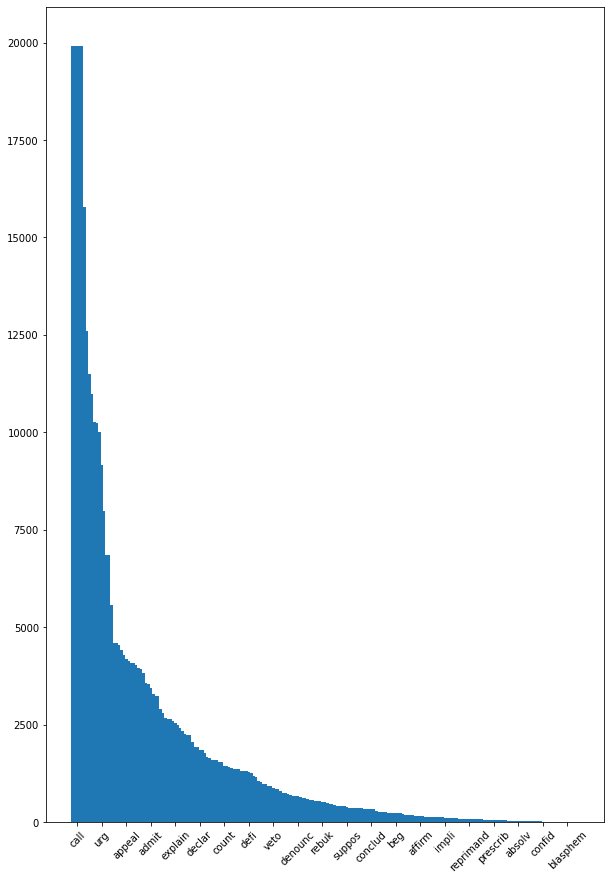

In [61]:
new_stem_search_counts=defaultdict(int)
hlines.stemmed_searchwords_long.apply(lambda x: search_word_counter(x,new_stem_search_counts))
new_stem_search_counts=pd.Series(new_stem_search_counts,name='counts')



f, ax = plt.subplots(figsize=(10,15))
ax1=plt.subplot(1,1,1);
plt.bar(new_stem_search_counts.sort_values(ascending=False).keys(),new_stem_search_counts.sort_values(ascending=False),width=5);
plt.xticks([key for i, key in enumerate(new_stem_search_counts.sort_values(ascending=False).keys()) if (i+10)%10==0],rotation=45);

In [35]:
new_stem_search_counts.sort_values(ascending=False)

call        19924
vote        15791
claim       12593
warn        11488
talk        10985
            ...  
interced        3
beseech         2
blasphem        1
infer           1
deduc           1
Name: counts, Length: 203, dtype: int64

In [0]:
hlines['short_number_list']=hlines.splitted_clean.apply(lambda x: intransletor(x,new_w2i))
hlines['searchwords_in_short_headline']=hlines.short_number_list.apply(lambda x:stringtranslator(x,new_i2w,999999))
hlines['stemmed_searchwords_short']=hlines['searchwords_in_short_headline'].apply(lambda x: [stem_dict[word] for word in x])

In [63]:
sh_len= len(hlines[hlines.searchwords_in_short_headline.apply(lambda x: len(x)>0)])
short = hlines[hlines.searchwords_in_short_headline.apply(lambda x: len(x)>0)]
print(" after removing the omitted words from the search list AND splitting on the ; markerwe are down to {} headlines in our dataset,\n{}% of the long dataset and {}% compared to the dataset with all searchwords".format(sh_len,
                                                                                                                                                                                                                             np.round(100*sh_len/len(hlines),2),
                                                                                                                                                                                                                             np.round(100*sh_len/len(headlines),2)))

 after removing the omitted words from the search list AND splitting on the ; markerwe are down to 184579 headlines in our dataset,
72.58% of the long dataset and 56.44% compared to the dataset with all searchwords


#POS analysis

In [0]:
#Run just once
#hlines['pos_searchwords_long']=hlines.cleaned_text.apply(lambda x: pos_translation(x,new_searchlist))  
#hlines.to_csv('hlines_stem_pos.csv')

In [70]:
hlines.head()

publication        date  \
2  The Daily Telegraph (London)  2016-12-31   
3  The Daily Telegraph (London)  2016-12-31   
4  The Daily Telegraph (London)  2016-12-31   
5  The Daily Telegraph (London)  2016-12-31   
7  The Daily Telegraph (London)  2016-12-31   

                                        cleaned_text  \
2  the ascent of household brand everest; the hom...   
3  city plan to pull the plug on klopp's heavy me...   
4  cause of pop star's death still unknown amid h...   
5  the world is not ready for killer flu epidemic...   
7  welcome to a very wet new year - but at least ...   

                                      splitted_clean  \
2              the ascent of household brand everest   
3  city plan to pull the plug on klopp's heavy metal   
4  cause of pop star's death still unknown amid h...   
5  the world is not ready for killer flu epidemic...   
7  welcome to a very wet new year - but at least ...   

                                    long_number_list  \
2  [999999, 999999, 999999, 999999, 999999, 99999...   
3  [999999, 999999, 999999, 999999, 999999, 99999...   
4  [999999, 999999, 999999, 999999, 999999, 99999...   
5  [999999, 999999, 999999, 999999, 999999, 99999...   
7  [758, 999999, 999999, 999999, 999999, 999999, ...   

  searchwords_in_long_headline stemmed_searchwords_long  \
2                     [thanks]                  [thank]   
3                     [warned]                   [warn]   
4                     [claims]                  [claim]   
5                      [warns]                   [warn]   
7                    [welcome]                 [welcom]   

                                   short_number_list  \
2   [999999, 999999, 999999, 999999, 999999, 999999]   
3  [999999, 999999, 999999, 999999, 999999, 99999...   
4  [999999, 999999, 999999, 999999, 999999, 99999...   
5  [999999, 999999, 999999, 999999, 999999, 99999...   
7  [758, 999999, 999999, 999999, 999999, 999999, ...   

  searchwords_in_short_headline stemmed_searchwords_short pos_searchwords_long  
2                            []                        []               [NOUN]  
3                            []                        []               [VERB]  
4                      [claims]                   [claim]               [NOUN]  
5                       [warns]                    [warn]               [VERB]  
7                     [welcome]                  [welcom]               [VERB]

In [0]:
 hlines['pos_searchwords_long'] = hlines.pos_searchwords_long.apply(lambda x: [x[i] for i in range (len(x))])
 hlines['pos_searchwords_in_long_headline'] = hlines['pos_searchwords_long'].apply(lambda x: [x[i] for i in range (len(x))])
 hlines['stemmed_searchwords_long'] = hlines['searchwords_in_long_headline'].apply(lambda x: [stem_dict[str(word)] for word in x])

In [0]:
long_stem_pos_dict = {}
hlines.apply(lambda x:search_pos_searchwords(x,long_stem_pos_dict,'stemmed_searchwords_long','pos_searchwords_long'),axis=1)
long_stem_pos_counts=pd.DataFrame(long_stem_pos_dict).T.fillna(0).astype(int)


# Time Series analysis



In [0]:
#hlines=pd.read_csv('hlines_stem_pos.csv')

In [74]:
long = hlines[['publication',	'date',	'cleaned_text',	'splitted_clean',	'searchwords_in_long_headline',	'stemmed_searchwords_long',	'pos_searchwords_long']]
long.columns = ['publication',	'date',	'cleaned_text',	'splitted_clean',	'searchwords_in_headline',	'stemmed_searchwords',	'pos_searchwords']

long.head()

publication        date  \
2  The Daily Telegraph (London)  2016-12-31   
3  The Daily Telegraph (London)  2016-12-31   
4  The Daily Telegraph (London)  2016-12-31   
5  The Daily Telegraph (London)  2016-12-31   
7  The Daily Telegraph (London)  2016-12-31   

                                        cleaned_text  \
2  the ascent of household brand everest; the hom...   
3  city plan to pull the plug on klopp's heavy me...   
4  cause of pop star's death still unknown amid h...   
5  the world is not ready for killer flu epidemic...   
7  welcome to a very wet new year - but at least ...   

                                      splitted_clean searchwords_in_headline  \
2              the ascent of household brand everest                [thanks]   
3  city plan to pull the plug on klopp's heavy metal                [warned]   
4  cause of pop star's death still unknown amid h...                [claims]   
5  the world is not ready for killer flu epidemic...                 [warns]   
7  welcome to a very wet new year - but at least ...               [welcome]   

  stemmed_searchwords pos_searchwords  
2             [thank]          [NOUN]  
3              [warn]          [VERB]  
4             [claim]          [NOUN]  
5              [warn]          [VERB]  
7            [welcom]          [VERB]

In [80]:
sents = long.apply(lambda x: sentiment_measure(x,sentiments_dict,'stemmed_searchwords' ), axis=1)
long['neg'],long['neu'],long['pos'] = sents.apply(lambda x:x[0]),sents.apply(lambda x:x[1]),sents.apply(lambda x:x[2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
long.date=pd.to_datetime(long.date, dayfirst=True)
long.date=long.date.fillna(method='ffill')
long.set_index('date',inplace=True)

In [0]:
daily = long.resample('D').sum()
weekly = long.resample('W').sum()
monthly = long.resample('M').sum()

daily_pre = pd.concat([pd.Series(daily[col])/daily.sum(axis=1) for col in daily.columns],axis=1)
daily_pre.columns=['neg','neu','pos']

weekly_pre = pd.concat([pd.Series(weekly[col])/weekly.sum(axis=1) for col in weekly.columns],axis=1)
weekly_pre.columns=['neg','neu','pos']

monthly_pre = pd.concat([pd.Series(monthly[col])/monthly.sum(axis=1) for col in monthly.columns],axis=1)
monthly_pre.columns=['neg','neu','pos']

In [87]:
long.head()

publication  \
date                                       
2016-12-31  The Daily Telegraph (London)   
2016-12-31  The Daily Telegraph (London)   
2016-12-31  The Daily Telegraph (London)   
2016-12-31  The Daily Telegraph (London)   
2016-12-31  The Daily Telegraph (London)   

                                                 cleaned_text  \
date                                                            
2016-12-31  the ascent of household brand everest; the hom...   
2016-12-31  city plan to pull the plug on klopp's heavy me...   
2016-12-31  cause of pop star's death still unknown amid h...   
2016-12-31  the world is not ready for killer flu epidemic...   
2016-12-31  welcome to a very wet new year - but at least ...   

                                               splitted_clean  \
date                                                            
2016-12-31              the ascent of household brand everest   
2016-12-31  city plan to pull the plug on klopp's heavy metal   
2016-12-31  cause of pop star's death still unknown amid h...   
2016-12-31  the world is not ready for killer flu epidemic...   
2016-12-31  welcome to a very wet new year - but at least ...   

           searchwords_in_headline stemmed_searchwords pos_searchwords  neg  \
date                                                                          
2016-12-31                [thanks]             [thank]          [NOUN]    0   
2016-12-31                [warned]              [warn]          [VERB]    1   
2016-12-31                [claims]             [claim]          [NOUN]    0   
2016-12-31                 [warns]              [warn]          [VERB]    1   
2016-12-31               [welcome]            [welcom]          [VERB]    0   

            neu  pos  
date                  
2016-12-31    0    1  
2016-12-31    0    0  
2016-12-31    1    0  
2016-12-31    0    0  
2016-12-31    0    1

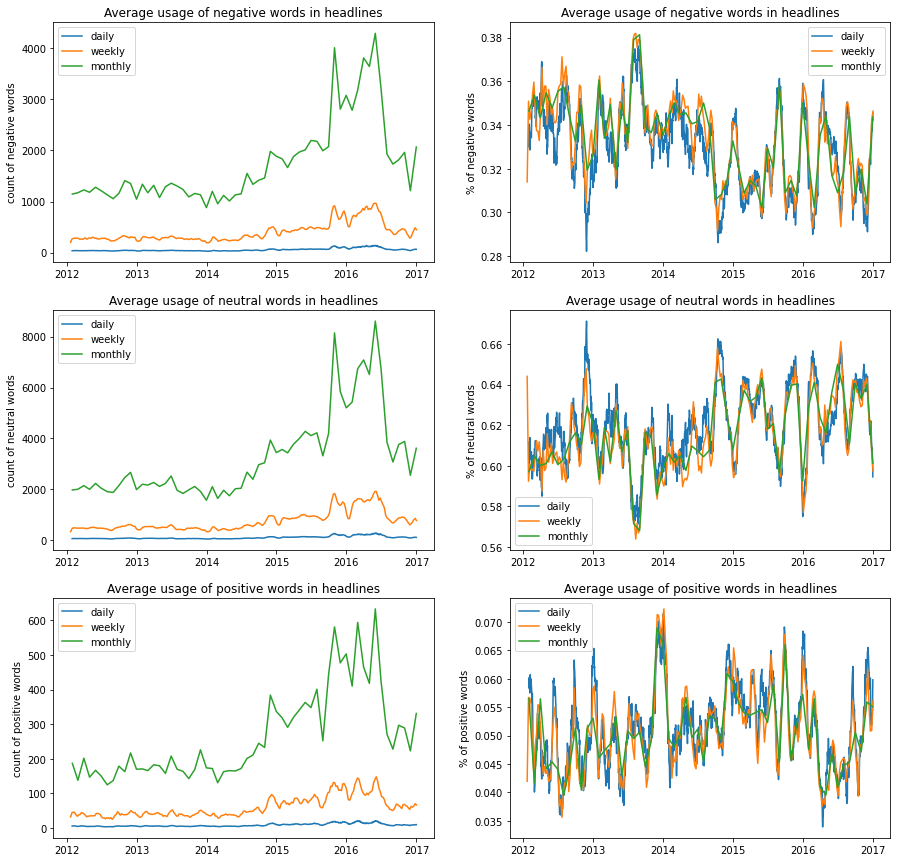

In [88]:
f, ax = plt.subplots(3,1,figsize=(15,15))
ax =plt.subplot(3,2,1)
ax =sns.lineplot( data = daily['neg'].rolling(30).mean(),label='daily')
ax =sns.lineplot( data = weekly['neg'].rolling(4).mean(),label = 'weekly')
ax = sns.lineplot( data = monthly['neg'],label = 'monthly')
ax = plt.title('Average usage of negative words in headlines')
ax = plt.ylabel ('count of negative words')

ax =plt.subplot(3,2,2)
ax =sns.lineplot( data = daily_pre['neg'].rolling(30).mean(),label='daily')
ax =sns.lineplot( data = weekly_pre['neg'].rolling(4).mean(),label = 'weekly')
ax = sns.lineplot( data = monthly_pre['neg'],label = 'monthly')
ax = plt.title('Average usage of negative words in headlines')
ax = plt.ylabel ('% of negative words')

ax =plt.subplot(3,2,3)
ax =sns.lineplot( data = daily['neu'].rolling(30).mean(),label='daily')
ax =sns.lineplot( data = weekly['neu'].rolling(4).mean(),label = 'weekly')
ax = sns.lineplot( data = monthly['neu'],label = 'monthly')
ax = plt.title('Average usage of neutral words in headlines')
ax = plt.ylabel ('count of neutral words')

ax =plt.subplot(3,2,4)
ax =sns.lineplot( data = daily_pre['neu'].rolling(30).mean(),label='daily')
ax =sns.lineplot( data = weekly_pre['neu'].rolling(4).mean(),label = 'weekly')
ax = sns.lineplot( data = monthly_pre['neu'],label = 'monthly')
ax = plt.title('Average usage of neutral words in headlines')
ax = plt.ylabel ('% of neutral words')


ax =plt.subplot(3,2,5)
ax =sns.lineplot( data = daily['pos'].rolling(30).mean(),label='daily')
ax =sns.lineplot( data = weekly['pos'].rolling(4).mean(),label = 'weekly')
ax = sns.lineplot( data = monthly['pos'],label = 'monthly')
ax = plt.title('Average usage of positive words in headlines')
ax = plt.ylabel ('count of positive words')


ax =plt.subplot(3,2,6)
ax =sns.lineplot( data = daily_pre['pos'].rolling(30).mean(),label='daily')
ax =sns.lineplot( data = weekly_pre['pos'].rolling(4).mean(),label = 'weekly')
ax = sns.lineplot( data = monthly_pre['pos'],label = 'monthly')
ax = plt.title('Average usage of positive words in headlines')
ax = plt.ylabel ('% of positive words')



##  interpetation
so in first glance it looks like there's an increase in the usage of XXX words in recent year, but unfortunatley that is not true.
what we see in the three plots on the left column is that we have a greater number of headlines from 2015 onwards, therefor we have higher frequencies for all the searchwords in recent years.

the plots on the right requeire some explanation:
plotting the raw number resulted in rigid, un-readable plots. what we see is the normalization of monthly measurments, measured in 3 ways:

simply monthly counts of neg, neu and pos words
rolling windows that take a time window of 4 weeks
rolling windows calculated over 30 days.
we can see that calculating monthly averages with 4 data points result in a noisy graph, but otherwise the 30 day measurments correlates highly with the monthly counts.

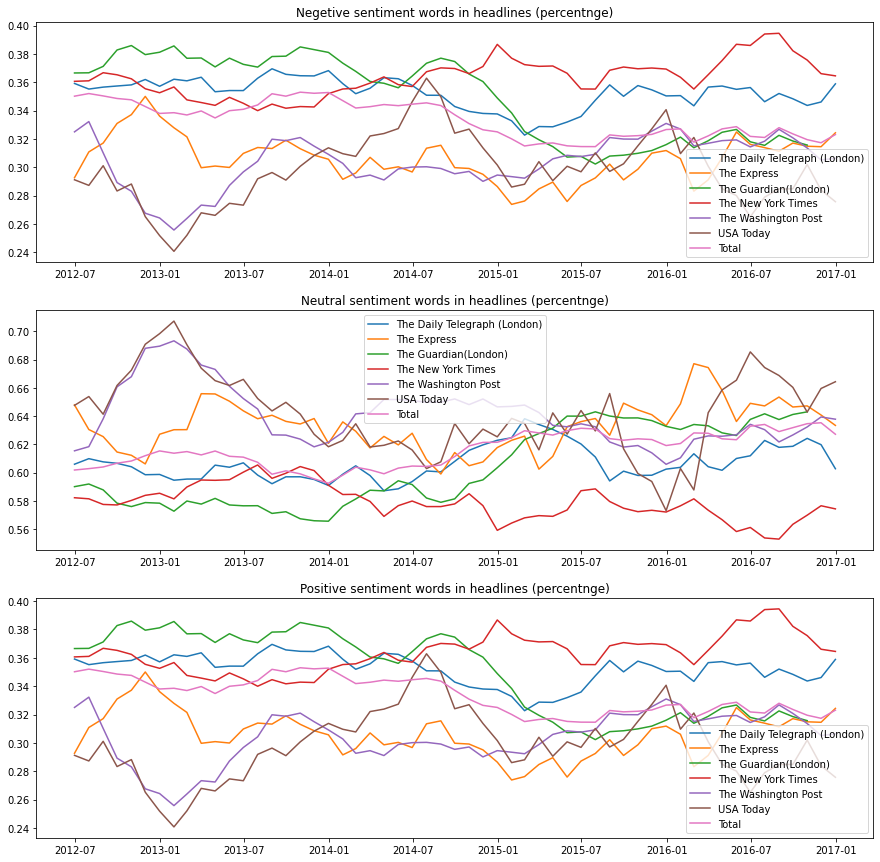

In [89]:
pubs=[]
labels=[]
for pub in long.publication.unique():
  month=long[long.publication==pub].resample('M').sum();
  month_pre = pd.concat([pd.Series(month[col])/long[long.publication==pub].resample('M').sum().sum(axis=1) for col in month.columns],axis=1);
  month_pre.columns=['neg','neu','pos'];
  pubs.append(month_pre)
  labels.append(pub)

month=long.resample('M').sum();
month_pre = pd.concat([pd.Series(month[col])/long.resample('M').sum().sum(axis=1) for col in month.columns],axis=1);
month_pre.columns=['neg','neu','pos'];
pubs.append(month_pre)
labels.append('Total')

F,ax = plt.subplots(3,1, figsize = (15,15));
ax = plt.subplot(3,1,1);
[sns.lineplot(data =  pubs[i]['neg'].rolling(6).mean(), label=labels[i]) for i in range(len(pubs))] ;
plt.title( 'Negetive sentiment words in headlines (percentnge)');

ax = plt.subplot(3,1,2);
[sns.lineplot(data =  pubs[i]['neu'].rolling(6).mean(), label=labels[i]) for i in range(len(pubs))] ;
plt.title( 'Neutral sentiment words in headlines (percentnge)');

ax = plt.subplot(3,1,3);
[sns.lineplot(data =  pubs[i]['neg'].rolling(6).mean(), label=labels[i]) for i in range(len(pubs))] ;
plt.title( 'Positive sentiment words in headlines (percentnge)');

## interpetation
this plot represent the monthly counts of each sentiment in headlines, averaged 6 months back. we can see temporal trends that affect each publication but NO general trend.

An intresting finding is the high correlation between USA Today and The Washington Post in the relative prevelance of sentimate related words in the headlines. that finding suggest that the news cycle isn't orgenizaed for the most part, but that similar news for papers that share the same cultural and political echo-system envoke similar responses.
The New York Times on the other hand, don't follow the same patterns established by the 2 other publications

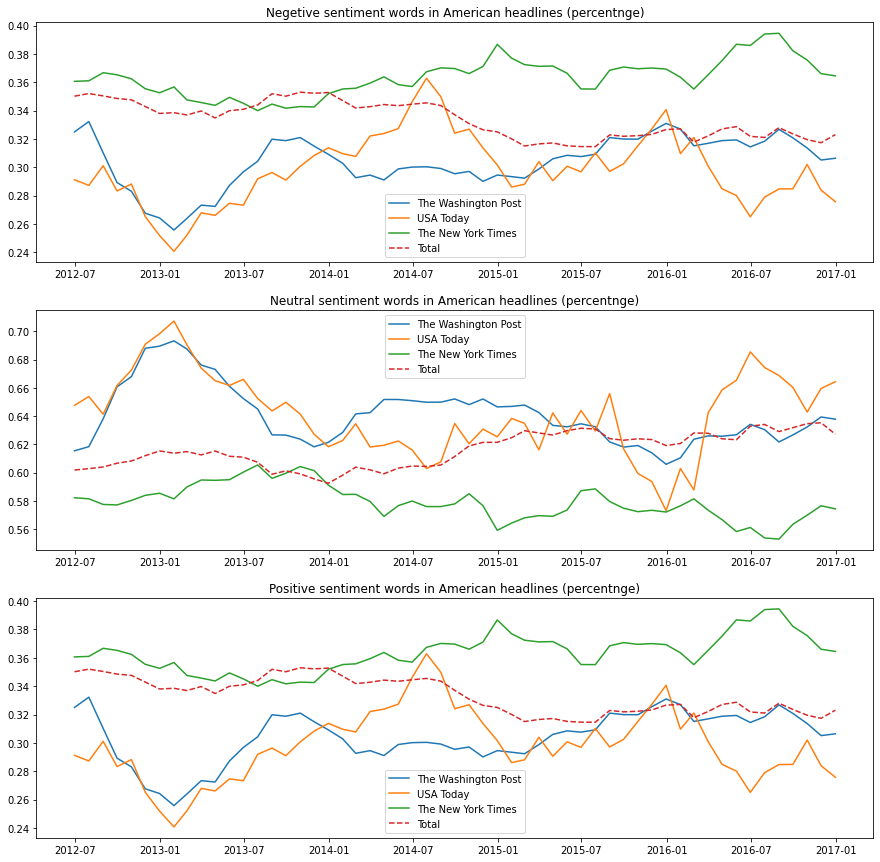

In [90]:
pubs=[]
labels=[]
lstle= ['-','-','-','--']
for pub in ['The Washington Post','USA Today', 'The New York Times']:
  month=long[long.publication==pub].resample('M').sum();
  month_pre = pd.concat([pd.Series(month[col])/long[long.publication==pub].resample('M').sum().sum(axis=1) for col in month.columns],axis=1);
  month_pre.columns=['neg','neu','pos'];
  pubs.append(month_pre)
  labels.append(pub)

month=long.resample('M').sum();
month_pre = pd.concat([pd.Series(month[col])/long.resample('M').sum().sum(axis=1) for col in month.columns],axis=1);
month_pre.columns=['neg','neu','pos'];
pubs.append(month_pre)
labels.append('Total')

F,ax = plt.subplots(3,1, figsize = (15,15));
ax = plt.subplot(3,1,1);
[plt.plot( pubs[i]['neg'].rolling(6).mean(), linestyle=lstle[i], label=labels[i]) for i in range(len(pubs))] ;
plt.title( 'Negetive sentiment words in American headlines (percentnge)');
plt.legend()

ax = plt.subplot(3,1,2);
[plt.plot(pubs[i]['neu'].rolling(6).mean(), linestyle=lstle[i], label=labels[i]) for i in range(len(pubs))] ;
plt.title( 'Neutral sentiment words in American headlines (percentnge)');
plt.legend()

ax = plt.subplot(3,1,3);
[plt.plot( pubs[i]['neg'].rolling(6).mean(), linestyle=lstle[i], label=labels[i]) for i in range(len(pubs))] ;
plt.title( 'Positive sentiment words in American headlines (percentnge)');
plt.legend()

## Weekly Averages
When looking at rolling 7-d averages for the relative frequency of each of the different sentiment we can see that the realation between the groups of words tend to stay stable over time.

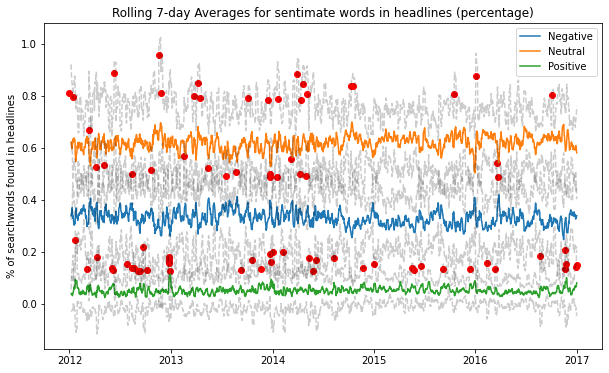

In [91]:

daily_means = pd.concat([pd.Series(long.resample('D').sum()[col]/long.resample('D').sum().sum(axis=1),name=col) for col in daily.columns],axis=1)
f,ax = plt.subplots(figsize=(10,6))
ax=plt.plot(daily_means.rolling(7).mean());
ax=plt.plot(daily_means.rolling(7).mean()+2.5*daily_means.rolling(7).std(),linestyle='--',alpha=0.2,color = 'black');
ax = plt.plot(daily_means.rolling(7).mean()-2.5*daily_means.rolling(7).std(),linestyle='--',alpha=0.2, color = 'black');

for col in daily_means.columns:
  ser=daily_means[col][(daily_means[col] > daily_means[col].mean()+2.5*daily_means[col].std())]#|(daily_means[col] < daily_means[col].mean()-2.5*daily_means[col].std())]
  ax = plt.scatter(ser.index,ser,color='red')

ax = plt.title('Rolling 7-day Averages for sentimate words in headlines (percentage)')
ax = plt.ylabel ('% of searchwords found in headlines')
ax = plt.legend(['Negative','Neutral','Positive']);

# Yearly analysis of sentiment in headlines

2013    36680
2014    41254
2015    65292
2016    73059
dtype: int64


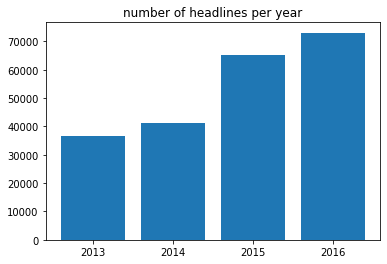

In [92]:
df_13 = date_zoom(long,long.index,'2013-01-01','2013-12-31')
df_14 = date_zoom(long,long.index,'2014-01-01','2014-12-31')
df_15 = date_zoom(long,long.index,'2015-01-01','2015-12-31')
df_16 = date_zoom(long,long.index,'2016-01-01','2016-12-31')

# comparison of number of publication
l = [df_13, df_14, df_15, df_16]

plt.bar([str(df.index.max())[:4] for df in l],[len(df) for df in l]);
plt.title('number of headlines per year')
print(pd.Series(dict(zip([str(df.index.max())[:4] for df in l],[len(df) for df in l]))))

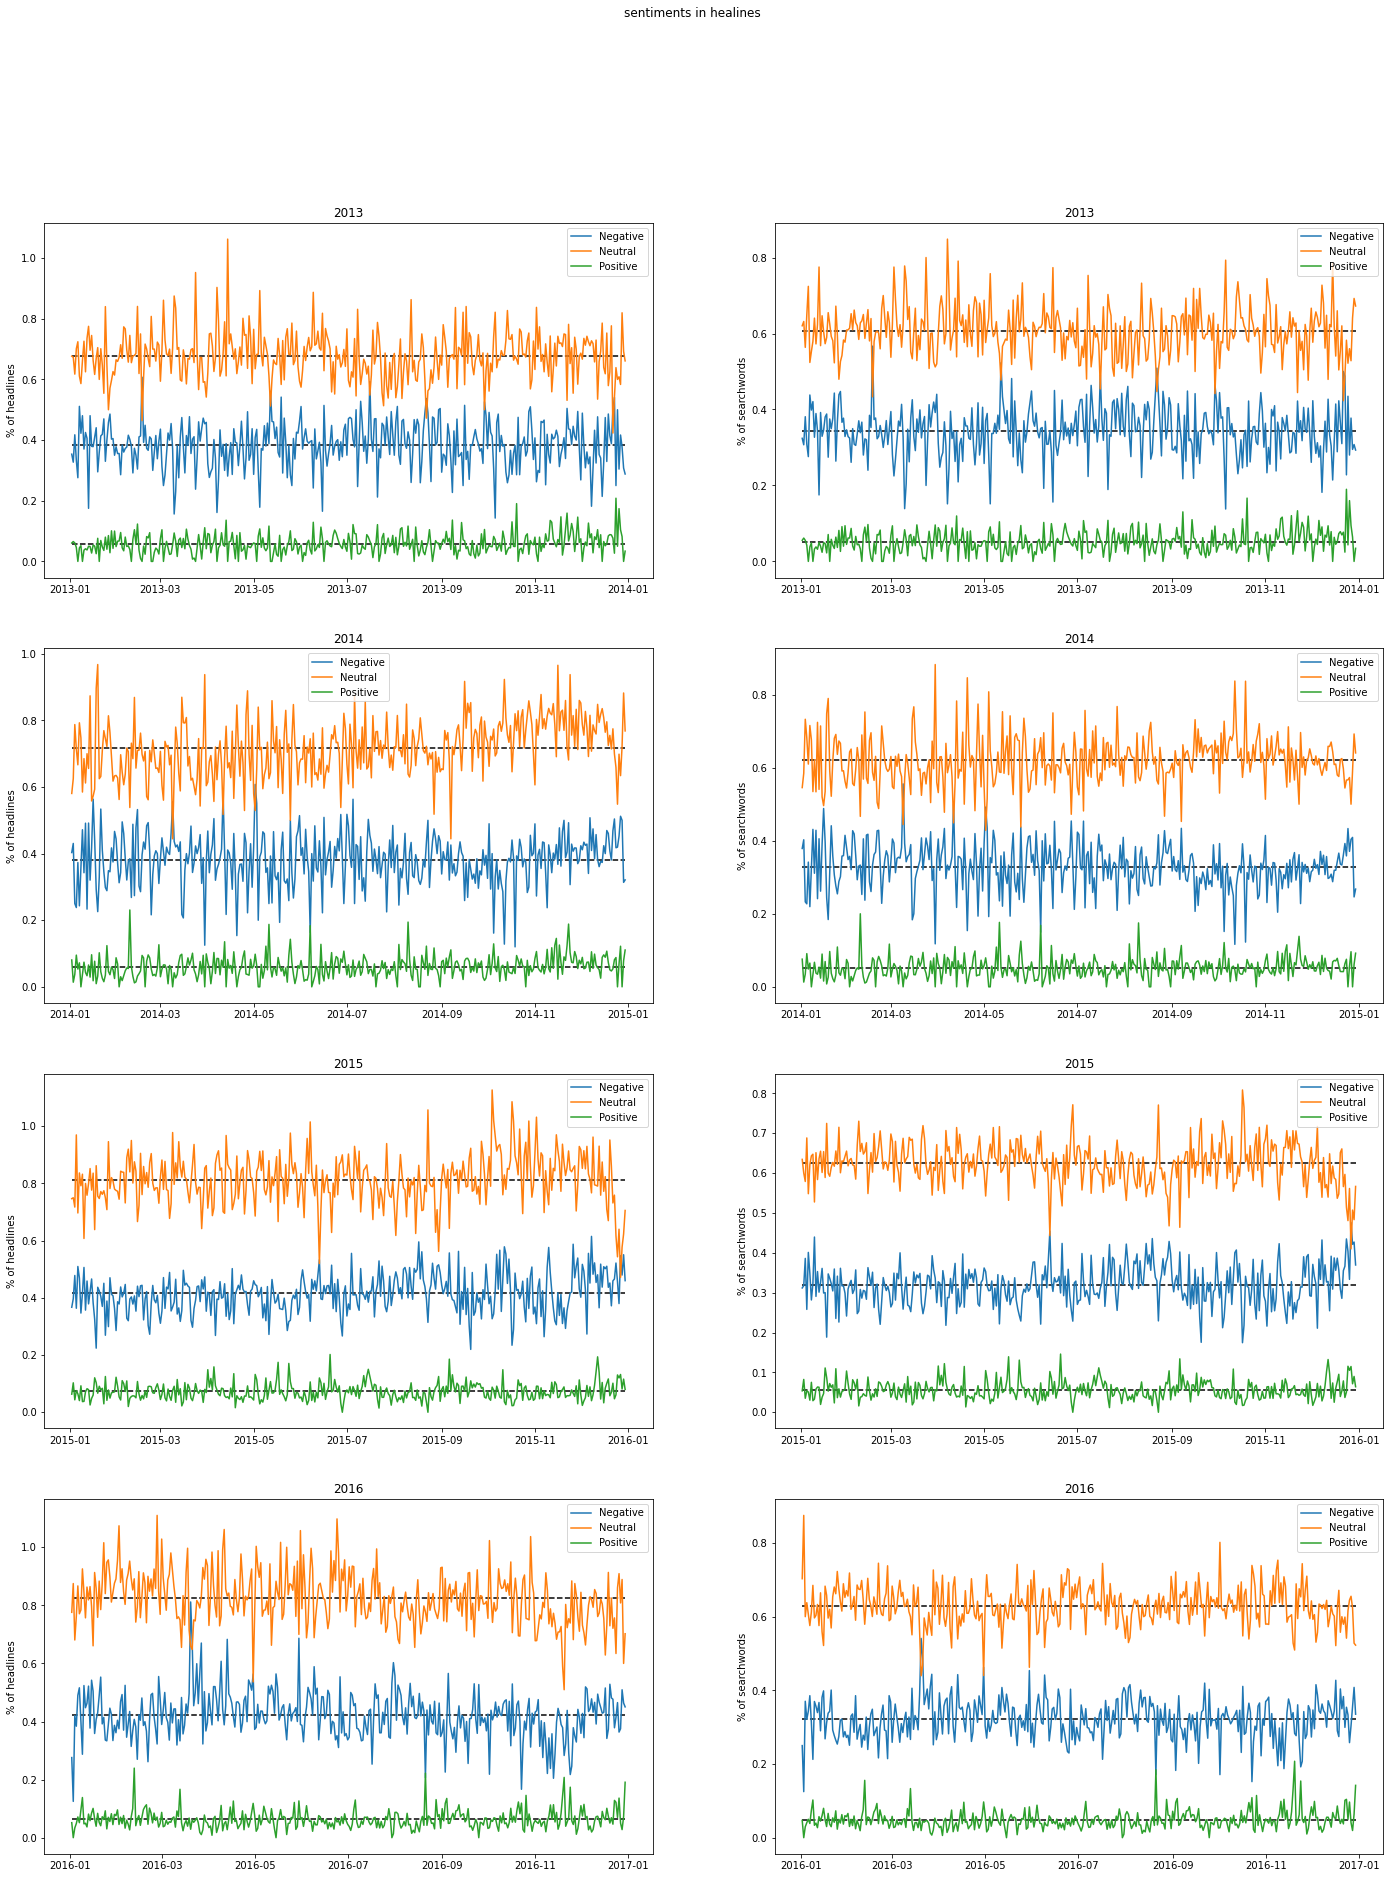

In [93]:

f, ax = plt.subplots(4,2,figsize=(24,30))
f.suptitle('sentiments in healines')

f.align_ylabels()

ax = plt.subplot(4,2,1)
ax = plt.plot(df_13[['neg','neu','pos']].resample('d').size().index,
              np.array(df_13[['neg','neu','pos']].resample('d').sum())/np.array(df_13[['neg','neu','pos']].resample('d').size()).reshape(-1,1))
plt.hlines([(np.array(df_13[['neg','neu','pos']].resample('d').sum())/np.array(df_13[['neg','neu','pos']].resample('d').size()).reshape(-1,1)).mean(axis=0)], 
           df_13.index.min(), df_13.index.max(), linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
ax = plt.ylabel('% of headlines')
ax = plt.title('2013')

ax = plt.subplot(4,2,2)
ax = plt.plot(df_13[['neg','neu','pos']].resample('d').size().index,
              np.array(df_13[['neg','neu','pos']].resample('d').sum())/np.array(df_13[['neg','neu','pos']].resample('d').sum().sum(axis=1)).reshape(-1,1))
ax = plt.title('relative share of sentiment related searchwords (from number of searchwords)')
plt.hlines([(np.array(df_13[['neg','neu','pos']].resample('d').sum())/np.array(df_13[['neg','neu','pos']].resample('d').sum().sum(axis=1)).reshape(-1,1)).mean(axis=0)], 
           df_13.index.min(), df_13.index.max(), linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
ax = plt.ylabel('% of searchwords')
ax = plt.title('2013')

ax = plt.subplot(4,2,3)
ax = plt.plot(df_14[['neg','neu','pos']].resample('d').size().index,
              np.array(df_14[['neg','neu','pos']].resample('d').sum())/np.array(df_14[['neg','neu','pos']].resample('d').size()).reshape(-1,1))
plt.hlines([(np.array(df_14[['neg','neu','pos']].resample('d').sum())/np.array(df_14[['neg','neu','pos']].resample('d').size()).reshape(-1,1)).mean(axis=0)], 
           df_14.index.min(), df_14.index.max(), linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
ax = plt.ylabel('% of headlines')
ax = plt.title('2014')

ax = plt.subplot(4,2,4)
ax = plt.plot(df_14[['neg','neu','pos']].resample('d').size().index,
              np.array(df_14[['neg','neu','pos']].resample('d').sum())/np.array(df_14[['neg','neu','pos']].resample('d').sum().sum(axis=1)).reshape(-1,1))
ax = plt.title('relative share of sentiment related searchwords (from number of searchwords)')
plt.hlines([(np.array(df_14[['neg','neu','pos']].resample('d').sum())/np.array(df_14[['neg','neu','pos']].resample('d').sum().sum(axis=1)).reshape(-1,1)).mean(axis=0)], 
           df_14.index.min(), df_14.index.max(), linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
ax = plt.ylabel('% of searchwords')
ax = plt.title('2014')

ax = plt.subplot(4,2,5)
ax = plt.plot(df_15[['neg','neu','pos']].resample('d').size().index,
              np.array(df_15[['neg','neu','pos']].resample('d').sum())/np.array(df_15[['neg','neu','pos']].resample('d').size()).reshape(-1,1))
plt.hlines([(np.array(df_15[['neg','neu','pos']].resample('d').sum())/np.array(df_15[['neg','neu','pos']].resample('d').size()).reshape(-1,1)).mean(axis=0)], 
           df_15.index.min(), df_15.index.max(), linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
ax = plt.ylabel('% of headlines')
ax = plt.title('2015')

ax = plt.subplot(4,2,6)
ax = plt.plot(df_15[['neg','neu','pos']].resample('d').size().index,
              np.array(df_15[['neg','neu','pos']].resample('d').sum())/np.array(df_15[['neg','neu','pos']].resample('d').sum().sum(axis=1)).reshape(-1,1))
ax = plt.title('relative share of sentiment related searchwords (from number of searchwords)')
plt.hlines([(np.array(df_15[['neg','neu','pos']].resample('d').sum())/np.array(df_15[['neg','neu','pos']].resample('d').sum().sum(axis=1)).reshape(-1,1)).mean(axis=0)], 
           df_15.index.min(), df_15.index.max(), linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
ax = plt.ylabel('% of searchwords')
ax = plt.title('2015')

ax = plt.subplot(4,2,7)
ax = plt.plot(df_16[['neg','neu','pos']].resample('d').size().index,
              np.array(df_16[['neg','neu','pos']].resample('d').sum())/np.array(df_16[['neg','neu','pos']].resample('d').size()).reshape(-1,1))
plt.hlines([(np.array(df_16[['neg','neu','pos']].resample('d').sum())/np.array(df_16[['neg','neu','pos']].resample('d').size()).reshape(-1,1)).mean(axis=0)], 
           df_16.index.min(), df_16.index.max(), linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
ax = plt.ylabel('% of headlines')
ax = plt.title('2016')

ax = plt.subplot(4,2,8)
ax = plt.plot(df_16[['neg','neu','pos']].resample('d').size().index,
              np.array(df_16[['neg','neu','pos']].resample('d').sum())/np.array(df_16[['neg','neu','pos']].resample('d').sum().sum(axis=1)).reshape(-1,1))
ax = plt.title('relative share of sentiment related searchwords (from number of searchwords)')
plt.hlines([(np.array(df_16[['neg','neu','pos']].resample('d').sum())/np.array(df_16[['neg','neu','pos']].resample('d').sum().sum(axis=1)).reshape(-1,1)).mean(axis=0)], 
           df_16.index.min(), df_16.index.max(), linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
ax = plt.ylabel('% of searchwords')
ax = plt.title('2016')


# U.K and U.S.A separation

In [94]:
origin = {'The Daily Telegraph (London)':'UK', 'The Express':'UK',
       'The Guardian(London)':'UK', 'The New York Times':'USA',
       'The Washington Post':'USA', 'USA Today':'USA'}
long['country'] = long.publication.apply(lambda x: origin[x])

#long = hlines[['publication',	'date',	'cleaned_text',	'splitted_clean',	'searchwords_in_long_headline',	'stemmed_searchwords_long',	'pos_searchwords_long','country','neg','neu','pos']]
#long.columns = ['publication',	'date',	'cleaned_text',	'splitted_clean',	'searchwords_in_headline',	'stemmed_searchwords',	'pos_searchwords','country','neg','neu','pos']

UK ,USA = long[long.country=='UK'].reset_index(), long[long.country=='USA'].reset_index()

long.head()

publication  \
date                                       
2016-12-31  The Daily Telegraph (London)   
2016-12-31  The Daily Telegraph (London)   
2016-12-31  The Daily Telegraph (London)   
2016-12-31  The Daily Telegraph (London)   
2016-12-31  The Daily Telegraph (London)   

                                                 cleaned_text  \
date                                                            
2016-12-31  the ascent of household brand everest; the hom...   
2016-12-31  city plan to pull the plug on klopp's heavy me...   
2016-12-31  cause of pop star's death still unknown amid h...   
2016-12-31  the world is not ready for killer flu epidemic...   
2016-12-31  welcome to a very wet new year - but at least ...   

                                               splitted_clean  \
date                                                            
2016-12-31              the ascent of household brand everest   
2016-12-31  city plan to pull the plug on klopp's heavy metal   
2016-12-31  cause of pop star's death still unknown amid h...   
2016-12-31  the world is not ready for killer flu epidemic...   
2016-12-31  welcome to a very wet new year - but at least ...   

           searchwords_in_headline stemmed_searchwords pos_searchwords  neg  \
date                                                                          
2016-12-31                [thanks]             [thank]          [NOUN]    0   
2016-12-31                [warned]              [warn]          [VERB]    1   
2016-12-31                [claims]             [claim]          [NOUN]    0   
2016-12-31                 [warns]              [warn]          [VERB]    1   
2016-12-31               [welcome]            [welcom]          [VERB]    0   

            neu  pos country  
date                          
2016-12-31    0    1      UK  
2016-12-31    0    0      UK  
2016-12-31    1    0      UK  
2016-12-31    0    0      UK  
2016-12-31    0    1      UK

# combined positive and negative words

having words that are both negative and positive in the same headline it's pretty weird, we can see that only in a handful of the headlines it occures, but what is also interesting is that given that a positive word has appeared in a headline. there's a about a 13.5% that it will be accompanied by a negative word.
that is interesting since positive words are pretty rare to brgin with.

In [95]:
posneg = long[(long.neg>0) & (long.pos>0)]
print(f'in {len(posneg)} headline there are both positive and negative words present.\n this are {np.round(100*len(posneg)/len(long),2)}% of the data points, {np.round(100*len(posneg)/len(long[long.pos>0]),2)}% of the positive instances and {np.round(100*len(posneg)/len(long[long.neg>0]),2)}% of the negative ones.')

100*(posneg.resample('d').size()/long.resample('d').size()[1:])

in 1668 headline there are both positive and negative words present.
 this are 0.66% of the data points, 10.81% of the positive instances and 1.8% of the negative ones.


date
2012-01-02    1.886792
2012-01-03    0.000000
2012-01-04    0.943396
2012-01-05    0.000000
2012-01-06    0.000000
                ...   
2016-12-27    0.000000
2016-12-28    0.000000
2016-12-29    0.909091
2016-12-30    4.580153
2016-12-31    1.234568
Freq: D, Length: 1826, dtype: float64

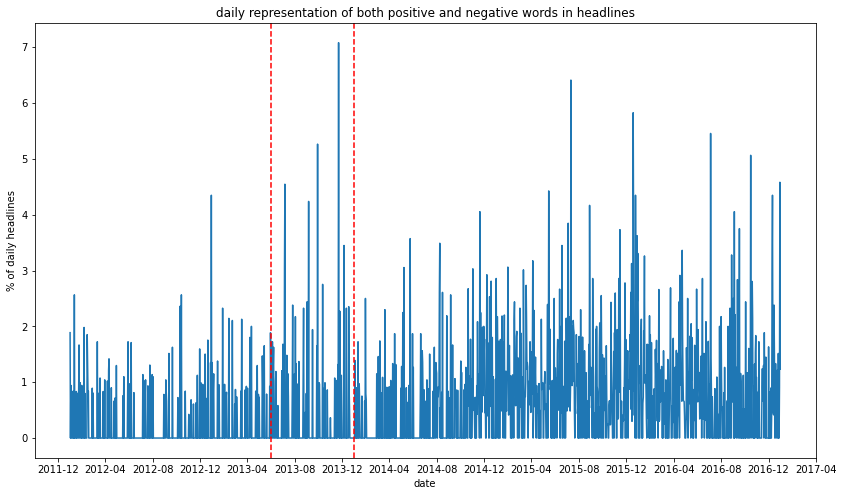

In [96]:
import matplotlib.dates as mdate

f,ax = plt.subplots(figsize = (14,8))
sns.lineplot(posneg.resample('d').size().index,100*(posneg.resample('d').size()/long.resample('d').size()[1:]))
plt.xlabel('date');
plt.ylabel('% of daily headlines');
plt.title('daily representation of both positive and negative words in headlines');
locator = mdate.MonthLocator(interval  = 4 )
plt.gca().xaxis.set_major_locator(locator)
#plt.axhline(6,color = 'r', linestyle = '--')
plt.axvline(pd.Timestamp('2013-06-01'),color='r',linestyle = '--')
plt.axvline(pd.Timestamp('2014-01-01'),color='r',linestyle = '--')

There are clearly some strange picks in the frequency of both positive and negative headlines around summer\fall of 2013.

let's Zoom in on that

In [0]:
summer13_daily = (date_zoom(daily,daily.index,'2013-06-01','2014-01-01').T/date_zoom(daily,daily.index,'2013-06-01','2014-01-01').sum(axis=1)).T
summer13_weekly = ( date_zoom(weekly,weekly.index,'2013-06-01','2014-01-01').T/date_zoom(weekly,weekly.index,'2013-06-01','2014-01-01').sum(axis=1)).T
summer13_monthly =  (date_zoom(monthly,monthly.index,'2013-06-01','2014-01-01').T/date_zoom(monthly,monthly.index,'2013-06-01','2014-01-01').sum(axis=1)).T

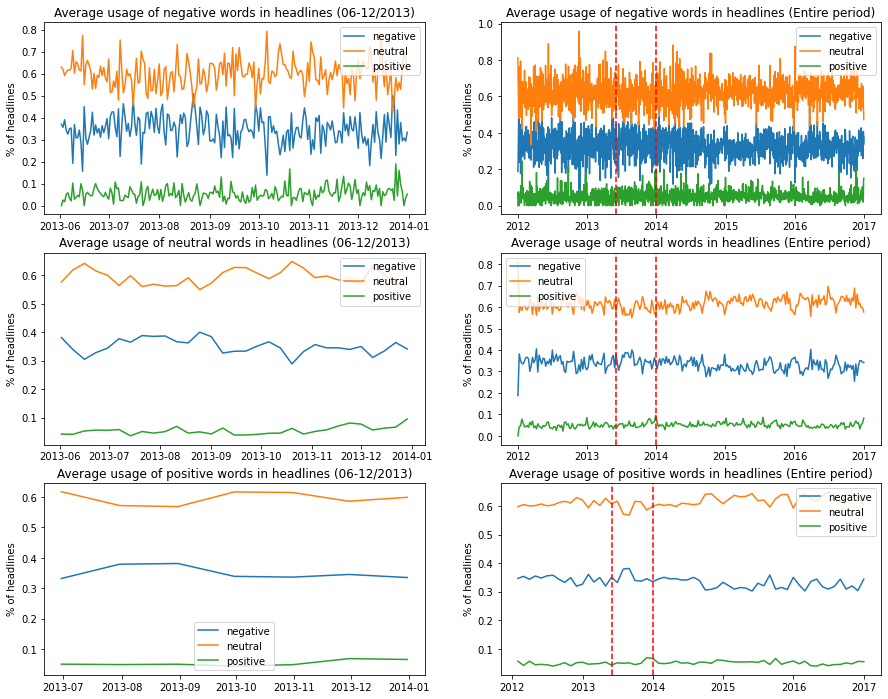

In [98]:
f, ax = plt.subplots(3,2,figsize=(15,12))

ax =plt.subplot(3,2,1)
ax =sns.lineplot( data = summer13_daily['neg'],label='negative')
ax =sns.lineplot( data = summer13_daily['neu'],label='neutral')
ax =sns.lineplot( data = summer13_daily['pos'],label='positive')
ax = plt.title('Average usage of negative words in headlines (06-12/2013)')
ax = plt.ylabel ('% of headlines')
plt.legend(loc= 0)

ax =plt.subplot(3,2,3)
ax =sns.lineplot( data = summer13_weekly['neg'],label = 'negative')
ax =sns.lineplot( data = summer13_weekly['neu'],label = 'neutral')
ax =sns.lineplot( data = summer13_weekly['pos'],label = 'positive')
ax = plt.title('Average usage of neutral words in headlines (06-12/2013)')
ax = plt.ylabel ('% of headlines')
plt.legend(loc= 0)

ax =plt.subplot(3,2,5)
ax = sns.lineplot( data = summer13_monthly['neg'],label = 'negative')
ax = sns.lineplot( data = summer13_monthly['neu'],label = 'neutral')
ax = sns.lineplot( data = summer13_monthly['pos'],label = 'positive')
ax = plt.title('Average usage of positive words in headlines (06-12/2013)')
ax = plt.ylabel ('% of headlines')
plt.legend(loc= 0)

ax =plt.subplot(3,2,2)
ax =sns.lineplot( data = daily['neg']/daily.sum(axis=1),label='negative')
ax =sns.lineplot( data = daily['neu']/daily.sum(axis=1),label='neutral')
ax =sns.lineplot( data = daily['pos']/daily.sum(axis=1),label='positive')
plt.axvline(pd.Timestamp('2013-06-01'),color='r',linestyle = '--')
plt.axvline(pd.Timestamp('2014-01-01'),color='r',linestyle = '--')
ax = plt.title('Average usage of negative words in headlines (Entire period)')
ax = plt.ylabel ('% of headlines')
plt.legend(loc= 0)

ax =plt.subplot(3,2,4)
ax =sns.lineplot( data = weekly['neg']/weekly.sum(axis=1),label = 'negative')
ax =sns.lineplot( data = weekly['neu']/weekly.sum(axis=1),label = 'neutral')
ax =sns.lineplot( data = weekly['pos']/weekly.sum(axis=1),label = 'positive')
plt.axvline(pd.Timestamp('2013-06-01'),color='r',linestyle = '--')
plt.axvline(pd.Timestamp('2014-01-01'),color='r',linestyle = '--')
ax = plt.title('Average usage of neutral words in headlines (Entire period)')
ax = plt.ylabel ('% of headlines')
plt.legend(loc= 0)

ax =plt.subplot(3,2,6)
ax = sns.lineplot( data = monthly['neg']/monthly.sum(axis=1),label = 'negative')
ax = sns.lineplot( data = monthly['neu']/monthly.sum(axis=1),label = 'neutral')
ax = sns.lineplot( data = monthly['pos']/monthly.sum(axis=1),label = 'positive')
plt.axvline(pd.Timestamp('2013-06-01'),color='r',linestyle = '--')
plt.axvline(pd.Timestamp('2014-01-01'),color='r',linestyle = '--')
ax = plt.title('Average usage of positive words in headlines (Entire period)')
ax = plt.ylabel ('% of headlines')
plt.legend(loc= 0)

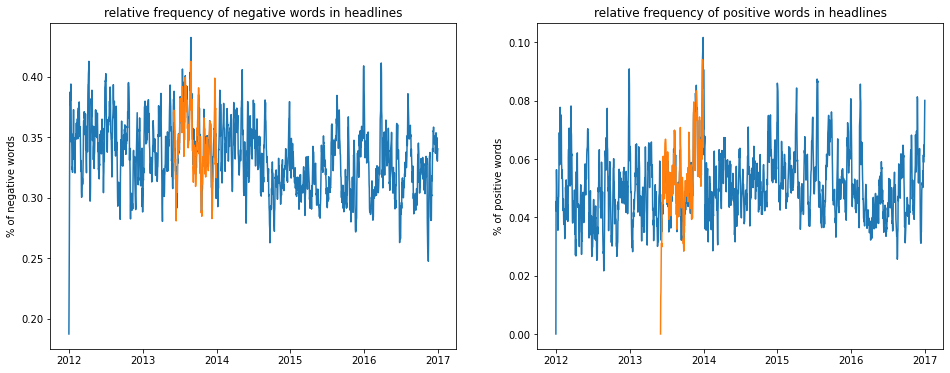

In [99]:
f, ax = plt.subplots(1,2,figsize = (16,6))

plt.subplot(1,2,1)
ax[0] = plt.plot(daily['neg'].rolling('7d').mean().T/daily.rolling('7d').mean().sum(axis=1))
ax[0] = plt.plot(summer13_daily['neg'].rolling('7d').mean())
ax[0] = plt.ylabel('% of negative words')
ax[0] = plt.title('relative frequency of negative words in headlines')

plt.subplot(1,2,2)
ax[1] = plt.plot(daily['pos'].rolling('7d').mean().T/daily.rolling('7d').mean().sum(axis=1))
ax[1] = plt.plot(summer13_daily['pos'].rolling('7d').mean())
ax[1] = plt.ylabel('% of positive words')
ax[1] = plt.title('relative frequency of positive words in headlines')

the interesting thing that we can see is that there is no real difference between the distribution of positive, neutral and negative words in the selected period compared to the entire selected period. it is possible that the picks that we've seen in 

In [100]:
long[long.country == 'UK'].loc[:,['neg','neu','pos']].sum()/len(long[long.country == 'UK'])

neg    0.443129
neu    0.821537
pos    0.061108
dtype: float64

In [101]:
long[long.country == 'USA'].loc[:,['neg','neu','pos']].sum()/len(long[long.country == 'USA'])

neg    0.362760
neu    0.702149
pos    0.064482
dtype: float64

# Selected Events Zoom in
In order to better understand the media's role in reality construction of real-life events, we will zoom in on some selected events from the examined time period.
for each of this events we will wxamine:

The distribution of positive\negative words in headlines around the time of the events.
the distribution of positive and negative words in headlines that relate directly to the topic
both for United states based publications and for UK based publication we will compare the difference in positive and negetive words frequency for domestic VS. foreign news.

### List of events for examination
2012
  - January: Iran - Eu relations (embargo) 
  - February: Greece bailout from EU 
  - September: Iran - Canada relations (cut) 
  - November: Obama elected **USA**
  - November 14th - 22nd: Israel-Palestine Gaza conflict 

2013
  - February 28th: Pope Benedict XVI resigns
  - March 13th: Pope Francis elected
  - March: Cyprus bailout of EU
  - June-July: Egypt military coup

2014
  - March-May: Russia’s Crimea annexation 
  - May 22nd - Thailand military coup
  - July: ISIS rise
  - July 8th -August 26th: Israel-Palestine Gaza conflict
  - September 18th : Scotland stays in UK **UK**
  - December 17th: US-Cube relations renewal **USA**


2015
  - March: Arab countries coalition against Houthis in Yemen
  - July: Greece debt crisis
  - July: Irun nuclear program agreement 
  - July: US-Cuba relationship renewal **USA**
  - November 13-14th: ISIS terror attack in Paris
  - November-December: global climate change agreement 

2016
  - January: Saudi Arabia - Iran relations (cut)
  - January: IAEA announce end of sanctions against Iran
  - March 20: Obamas’ visit to Cuba **USA**
  - March 22: ISIS terror attack in Brussels
  - June 23: Brexit referendum **UK**
  - June: ISIS terror attack in Istanbul
  - September: US and China join Paris climate agreement
  - September 9th : N. Korea nuclear test
  - November 8th: Trump elected **USA**
  - December: US withdrawal from Afghanistan **USA**<br>

  At a later stage we might want to divide these events into groups based on their subject (personal politics\military conflicts\ diplomacy \ etc.)<br>

Different news stories stay in the news sycle for changing periods of time, the time windows that we will choose for each news event depends on the duration of the events, we will choose changing time windows to examine different events.   


In [0]:
UK.date=pd.to_datetime(UK.date, dayfirst=True)
UK.date=UK.date.fillna(method='ffill')
UK.set_index('date',inplace=True)

USA.date=pd.to_datetime(USA.date, dayfirst=True)
USA.date=USA.date.fillna(method='ffill')
USA.set_index('date',inplace=True)

In [0]:
#1. Iran Embrago - Since it is less realated to a specific date, we will examine the ompact of this event on a large time window (about a month)
Jan12 = date_zoom(long,long.index,'2012-01-01','2012-02-01')

#2. Greece bailout (21.2) -  a rolling event that lasted for a few weeks
Feb12 =  date_zoom( long,long.index,'2012-02-15','2012-03-15')

#3. Canada - Iran Relation Cut 
Sep12  = date_zoom ( long,long.index,'2012-09-05','2012-10-05')

#4 Obama's re-election - singular event ****USA*****
Obama = date_zoom( long,long.index,'2012-11-05','2012-11-10')
US_obama = date_zoom( USA , USA.index,'2012-11-05','2012-11-10')
UK_obama =date_zoom( USA,USA.index,'2012-11-05','2012-11-10')

#5 Israel-Gaza conflict
Nov12 = date_zoom( long,long.index,'2012-11-14','2012-11-23')

#6 Benedictus resignation + Francis election
POPE13 = date_zoom (long,long.index, '2013-02-26','2013-03-17')

#7 Cyprus bailout
March13  = date_zoom(long,long.index, '2013-03-20','2013-04-05')

#8 Egypt coup d'tat
July13 = date_zoom(long,long.index, '2013-06-28','2013-07-10')

#9 Crimea's annexation
March14 = date_zoom(long,long.index, '2014-02-20','2014-03-30')

#10 Thailand's Coup d'etat
May14 = date_zoom(long,long.index, '2014-05-20','2014-05-31')

#11 ISIS Rise
July14 = date_zoom(long,long.index, '2014-06-28','2014-07-31')

#12 Israel-Gaza conflict #2
JulAug14 = date_zoom(long,long.index, '2014-07-08','2014-08-25')

#13 Scottish refferendum ****UK****
Sep14 = date_zoom(long,long.index, '2014-09-15','2014-09-25')
USreff =date_zoom(USA,USA.index, '2014-09-15','2014-09-25')
UKreff =date_zoom(UK,UK.index, '2014-09-15','2014-09-25') 

#14 US-Cube relations renewal ****USA****
dec14 = date_zoom(long,long.index, '2014-12-12','2014-12-25')
UScuba =date_zoom(USA,USA.index, '2014-12-12','2014-12-25')
UKcuba =date_zoom(UK,UK.index, '2014-12-15','2014-12-25') 

#15 Yemen crisis
March15 = date_zoom(long,long.index, '2015-03-15','2015-04-15')

#16 Greece debt crisis
#17 Iran nuclear agreement ****both US & UK****
July15 = date_zoom(long,long.index, '2015-06-22','2015-07-30')
USiran = date_zoom(long,long.index, '2015-06-22','2015-07-30')
UKiran = date_zoom(long,long.index, '2015-06-22','2015-07-30')

#18 ISIS Paris attacks
Nov15 = date_zoom(long,long.index, '2015-11-13','2015-11-20')

#19 Paris agreement
Dec15 = date_zoom(long,long.index, '2015-11-28','2015-12-28')

#20 Iran- Saudi Arabia Cut
#21 Iran sanctions lifting
Jan16 = date_zoom(long,long.index, '2016-01-01','2016-01-28')

#22  Obamas’ visit to Cuba ***USA***
#23 ISIS brusseles
March16 = date_zoom(long,long.index, '2016-03-15','2016-03-28')
USvisit = date_zoom(USA,USA.index, '2016-03-15','2016-03-28')
UKvisit = date_zoom(UK,UK.index, '2016-03-15','2016-03-28')

#24 Brexit referrendum 
#25 ISIS terror attack in Istanbul
June16 = date_zoom(long,long.index, '2016-06-18','2016-06-30')
USbrexit = date_zoom(USA,USA.index, '2016-06-18','2016-06-30')
UKbrexit = date_zoom(UK,UK.index, '2016-06-18','2016-06-30')


#26 US and China join Paris climate agreement
#27 N. Korea nuclear test
Sep16 = date_zoom(long,long.index, '2016-09-01','2016-09-20')

#28 Trump election ****USA***
Nov16 =  date_zoom(long,long.index, '2016-11-05','2016-11-15')
UStrump =  date_zoom(USA,USA.index, '2016-11-05','2016-11-15')
UKtrump =  date_zoom(UK,UK.index, '2016-11-05','2016-11-15')

#29 US Withdrawl from Afghanistan
Dec16 =  date_zoom(long,long.index, '2016-12-15','2016-12-31')
USafg =  date_zoom(USA,USA.index,  '2016-12-15','2016-12-31')
UKafg =  date_zoom(UK,UK.index,  '2016-12-15','2016-12-31')



In [0]:
def find_related(df,col,kw):
  return df[col].apply(lambda x: any(key in x for key in kw))

def calc_sent(df,rel,cols):
  return df[rel].loc[:,cols]

# Event exploration

out of 75 hadlines that are related to this topic, 33 contain negetive words, 6 contain positive words, and 37 contain neutral words
0 contains both positive and negitive words 


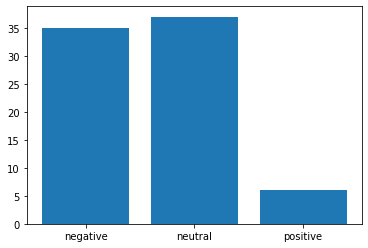

In [105]:
#1 . Iran embargo
keywords = ['iran','sanctiones','embargo']

related = find_related(Jan12,'cleaned_text',keywords) 
#print(Jan12.columns)
#print(Jan12.loc[:,['cleaned_text','stemmed_searchwords','neg','neu','pos']])                   
sentiment = calc_sent(Jan12,related,['cleaned_text','stemmed_searchwords','neg','neu','pos'])
tot, neg, pos, neu = related.sum(), (sentiment['neg']>0).sum() ,(sentiment['pos']>0).sum() ,(sentiment['neu']>0).sum()
both = ((sentiment['pos']>0) & (sentiment['neg']>0)).sum()


print(f'out of {tot} hadlines that are related to this topic, {neg} contain negetive words, {pos} contain positive words, and {neu} contain neutral words\n{both} contains both positive and negitive words ')

plt.bar(['negative','neutral','positive'],sentiment.iloc[:,2:].sum());

In [106]:
len(Jan12)

2944

out of 41 hadlines that are related to this topic, 12 contain negetive words, 4 contain positive words, and 28 contain neutral words
1 contains both positive and negitive words 
the headlines that contain both positive and negative headlines:
financial: hopes rise for greek bailout deal as athens finds new budget. cuts: commission chief barroso praises people's courage: dutch call for delay until after april elections 


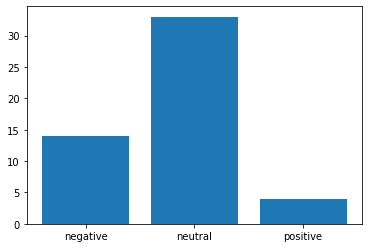

In [107]:
#2. Greece bailout (21.2) -  a rolling event that lasted for a few weeks
keywords = ['greece','bailout']


related = find_related(Feb12,'cleaned_text',keywords)                    
sentiment = calc_sent(Feb12,related,['cleaned_text','stemmed_searchwords','neg','neu','pos'])
tot, neg, pos, neu = related.sum(), (sentiment['neg']>0).sum() ,(sentiment['pos']>0).sum() ,(sentiment['neu']>0).sum()
both = ((sentiment['pos']>0) & (sentiment['neg']>0)).sum()


print(f'out of {tot} hadlines that are related to this topic, {neg} contain negetive words, {pos} contain positive words, and {neu} contain neutral words\n{both} contains both positive and negitive words ')

if both>0:
  print ('the headlines that contain both positive and negative headlines:\n{}'.format(sentiment[(sentiment['pos']>0) & (sentiment['neg']>0)]['cleaned_text'].values[0]))
plt.bar(['negative','neutral','positive'],sentiment.iloc[:,2:].sum());


out of 11 hadlines that are related to this topic, 5 contain negetive words, 0 contain positive words, and 6 contain neutral words
0 contains both positive and negitive words 


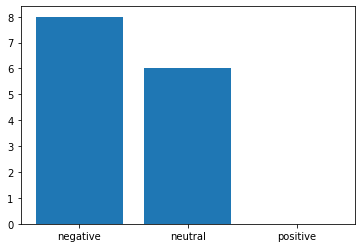

In [108]:
#3. Canada - Iran Relation Cut 
keywords = ['Canda','Iran','sanctions']


related = find_related(Sep12,'cleaned_text',keywords)                    
sentiment = calc_sent(Sep12,related,['cleaned_text','stemmed_searchwords','neg','neu','pos'])
tot, neg, pos, neu = related.sum(), (sentiment['neg']>0).sum() ,(sentiment['pos']>0).sum() ,(sentiment['neu']>0).sum()
both = ((sentiment['pos']>0) & (sentiment['neg']>0)).sum()


print(f'out of {tot} hadlines that are related to this topic, {neg} contain negetive words, {pos} contain positive words, and {neu} contain neutral words\n{both} contains both positive and negitive words ')

if both>0:
  print ('the headlines that contain both positive and negative headlines:\n{}'.format(sentiment[(sentiment['pos']>0) & (sentiment['neg']>0)]['cleaned_text'].values[0]))
plt.bar(['negative','neutral','positive'],sentiment.iloc[:,2:].sum());




0.004098360655737705

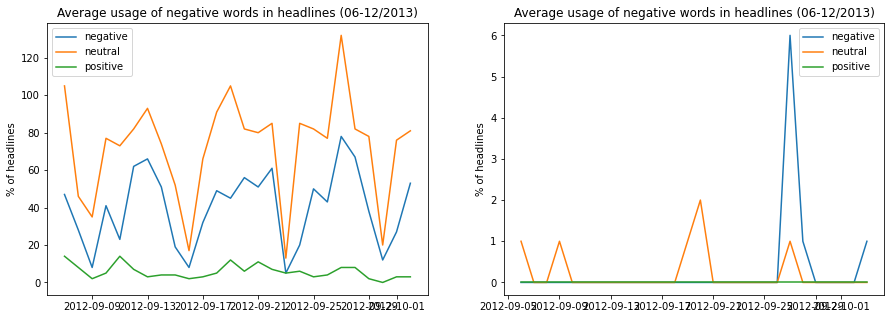

In [109]:
zz = date_zoom(long,long.index,min(sorted(sentiment.index.unique())),max(sorted(sentiment.index.unique())))

f, ax = plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1)
ax =sns.lineplot( data = zz['neg'].resample('d').sum(),label='negative')
ax =sns.lineplot( data = zz['neu'].resample('d').sum(),label='neutral')
ax =sns.lineplot( data = zz['pos'].resample('d').sum(),label='positive')
ax = plt.title('Average usage of negative words in headlines (06-12/2013)')
ax = plt.ylabel ('% of headlines')

plt.subplot(1,2,2)
ax =sns.lineplot( data = sentiment['neg'].resample('d').sum(),label='negative',ci = None)
ax =sns.lineplot( data = sentiment['neu'].resample('d').sum(),label='neutral',ci = None)
ax =sns.lineplot( data = sentiment['pos'].resample('d').sum(),label='positive',ci = None)
ax = plt.title('Average usage of negative words in headlines (06-12/2013)')
ax = plt.ylabel ('% of headlines')
plt.legend(loc= 0)
len(sentiment)/len(zz)

# Brexit, Trump, ISIS
after looking into some examples we seen that it is not that common for a single story to dominate the news cycle in a way that dictates the general sentiment.<br>
we have decided to reduce the number of event examined and to focus our examination on events that are:<br>
- A. singular - can be traced to a singular date
- B. dramatic - dominate a large part of the news cycles, meaning that a large part of the headlines deal directly with those events
- C. Unfolding - can be examined over the next few weeks of their happening<br>

We chose 3 Major news events: <br>
1. Brexit refferendum (June 23, 2016) - chosen because it is a dramatic event, widely covered, and affects directly UK
2. 2016 Presidential election  (November 8, 2016) - chosen because it is a dramatic event, widely covered, and affects directly USA.<br>

Both this events can be examined both in the time prior, and the aftermath.

3. ISIS terror attack in Paris (November 13, 2015) - chosen as a control example since it's a major event, but it not dirctly relates to USA nor UK. another difference is that this event was unplanned so we cannot examine the inpact of the event in the time prior to it's happening.

In [0]:
brexit = date_zoom(long,long.index, '2016-05-23','2016-07-23')
USbrexit = date_zoom(USA,USA.index, '2016-05-23','2016-07-23')
UKbrexit = date_zoom(UK,UK.index, '2016-05-23','2016-07-23')

trump =  date_zoom(long,long.index, '2016-10-08','2016-12-08')
UStrump =  date_zoom(USA,USA.index, '2016-10-08','2016-12-08')
UKtrump =  date_zoom(UK,UK.index, '2016-10-08','2016-12-08')

paris = date_zoom(long,long.index, '2015-11-13','2015-12-13')
parisUSA = date_zoom(USA,USA.index, '2015-11-13','2015-12-13')
parisUK = date_zoom(UK,UK.index, '2015-11-13','2015-12-13')

### Brexit

out of 13644 headlines in the 2 month surrounding the event, 2063 dirrectly mentioned it (15.12).
at the day of the event itself out of 288 headlines,52 directly mentioned it.
659 headlines contain negetive words, 65 contain positive words, and 1740 contain neutral words
8 contains both positive and negitive words
example of a headline that contain both positive and negative headlines:
'stampeding backwards': us officials in northern ireland peace deal decry. brexit; diplomats involved in good friday agreement warn against 'horrendous' prospect of a hard border between northern ireland and republic of ireland 


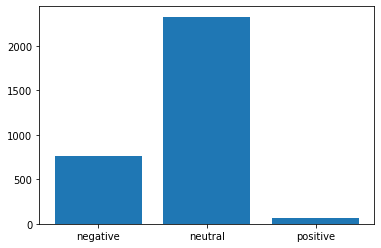

In [111]:
keywords = ['brexit','referendum','ukip']


related = find_related(brexit,'cleaned_text',keywords)                    
sentiment = calc_sent(brexit,related,['cleaned_text','stemmed_searchwords','neg','neu','pos'])
tot, neg, pos, neu = related.sum(), (sentiment['neg']>0).sum() ,(sentiment['pos']>0).sum() ,(sentiment['neu']>0).sum()
both = ((sentiment['pos']>0) & (sentiment['neg']>0)).sum()


related_UK = find_related(UKbrexit,'cleaned_text',keywords)                    
sentiment_UK = calc_sent(UKbrexit,related_UK,['cleaned_text','stemmed_searchwords','neg','neu','pos'])

related_US = find_related(USbrexit,'cleaned_text',keywords)                    
sentiment_US = calc_sent(USbrexit,related_US,['cleaned_text','stemmed_searchwords','neg','neu','pos'])

print(f'out of {len(brexit)} headlines in the 2 month surrounding the event, {len(brexit[related])} dirrectly mentioned it ({np.round(100*len(brexit[related])/len(brexit),2)}).')
print(f'at the day of the event itself out of {len(brexit[brexit.index=="2016-06-23"])} headlines,{len(brexit[related][brexit[related].index=="2016-06-23"])} directly mentioned it.')
print(f'{neg} headlines contain negetive words, {pos} contain positive words, and {neu} contain neutral words\n{both} contains both positive and negitive words')

if both>0:
  print ('example of a headline that contain both positive and negative headlines:\n{}'.format(sentiment[(sentiment['pos']>0) & (sentiment['neg']>0)]['cleaned_text'].values[0]))
plt.bar(['negative','neutral','positive'],sentiment.iloc[:,2:].sum());

### Sentiment in news coverage

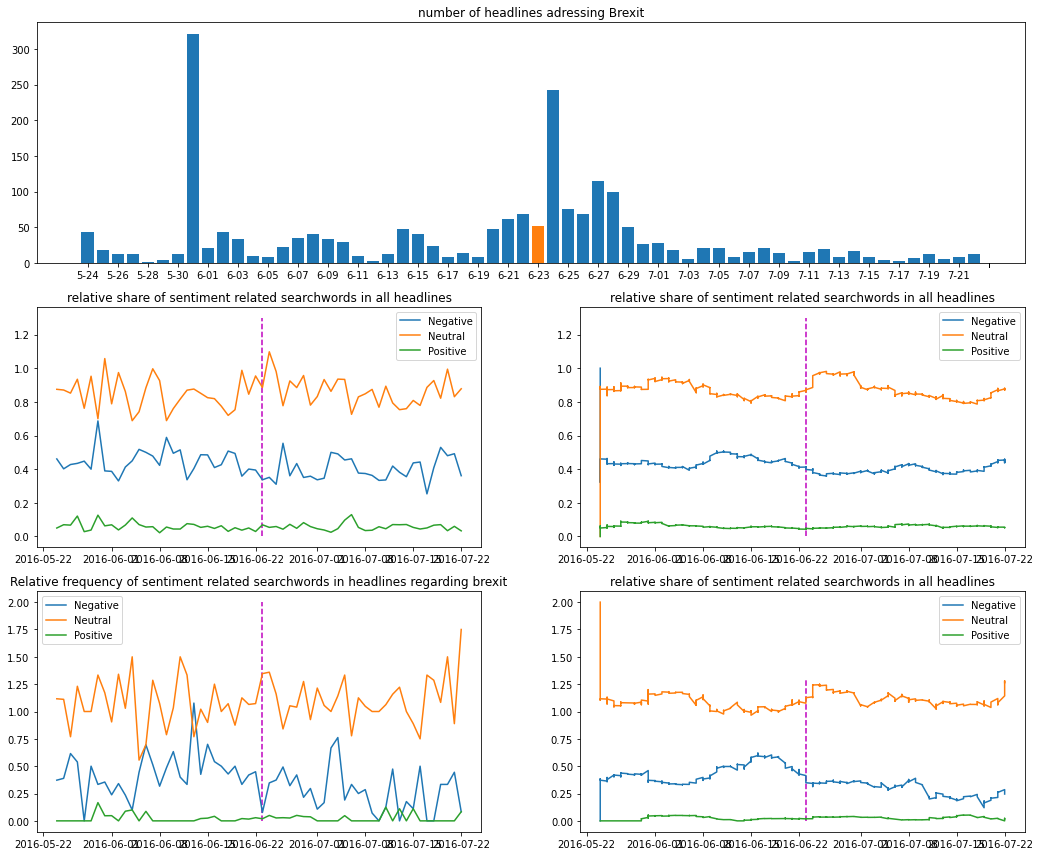

In [112]:
f,ax = plt.subplots(3,2,figsize=(15,12))


ax = plt.subplot(3,2,(1,2))
ticks = [str(d)[6:10] for d in (sentiment.resample('d').size()).index]
ax = plt.bar(ticks,sentiment.resample('d').size())
ax = plt.bar('6-23',sentiment[sentiment.index == '2016-06-23'].resample('d').size())
ax = plt.xticks([t if i%2==0 else ' 'for i,t in enumerate(ticks)])
plt.title('number of headlines adressing Brexit')


ax = plt.subplot(3,2,3)
ax = plt.plot(pd.concat([brexit.resample('d').sum()[col]/brexit.resample('d').size() for col in ['neg','neu','pos']],axis=1))
ax = plt.vlines(dt.datetime(2016, 6, 23),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')


ax = plt.subplot(3,2,4)
ax = plt.plot(brexit.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2016, 6, 23),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')

ax = plt.subplot(3,2,5)

ax = plt.plot(pd.concat([sentiment.resample('d').sum()[col]/sentiment.resample('d').size() for col in ['neg','neu','pos']],axis=1))
ax = plt.vlines(dt.datetime(2016, 6, 23),0,2, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('Relative frequency of sentiment related searchwords in headlines regarding brexit')


ax = plt.subplot(3,2,6)
ax = plt.plot(sentiment.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2016, 6, 23),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')

plt.tight_layout()

on the left  we see the daily amounts of searchwords regarding different santiments as raw data point.<br> in the right hand see the trends calculated as rolling averages of 7 day periods.<br>

Where there was no significant effect of the brexit on the general portion of the different sentiment words, we can see that when we take the counts as rolling averages, we can clearly see a upwards trend in the days leading to the refferendum, and a downwards trend in the days following the refferendum **in the use of negetive words only**

In [113]:
print (f'while in the UK the Brexit was mentioned in {len(sentiment_UK)}({np.round(100*len(sentiment_UK)/len(UKbrexit),2)}%), in the USA newspapers, the brexit was mentoined in {len(sentiment_US)}({np.round(100*len(sentiment_US)/len(USbrexit),2)}%) headlines in the same time peroid')

while in the UK the Brexit was mentioned in 1893(21.86%), in the USA newspapers, the brexit was mentoined in 170(3.41%) headlines in the same time peroid


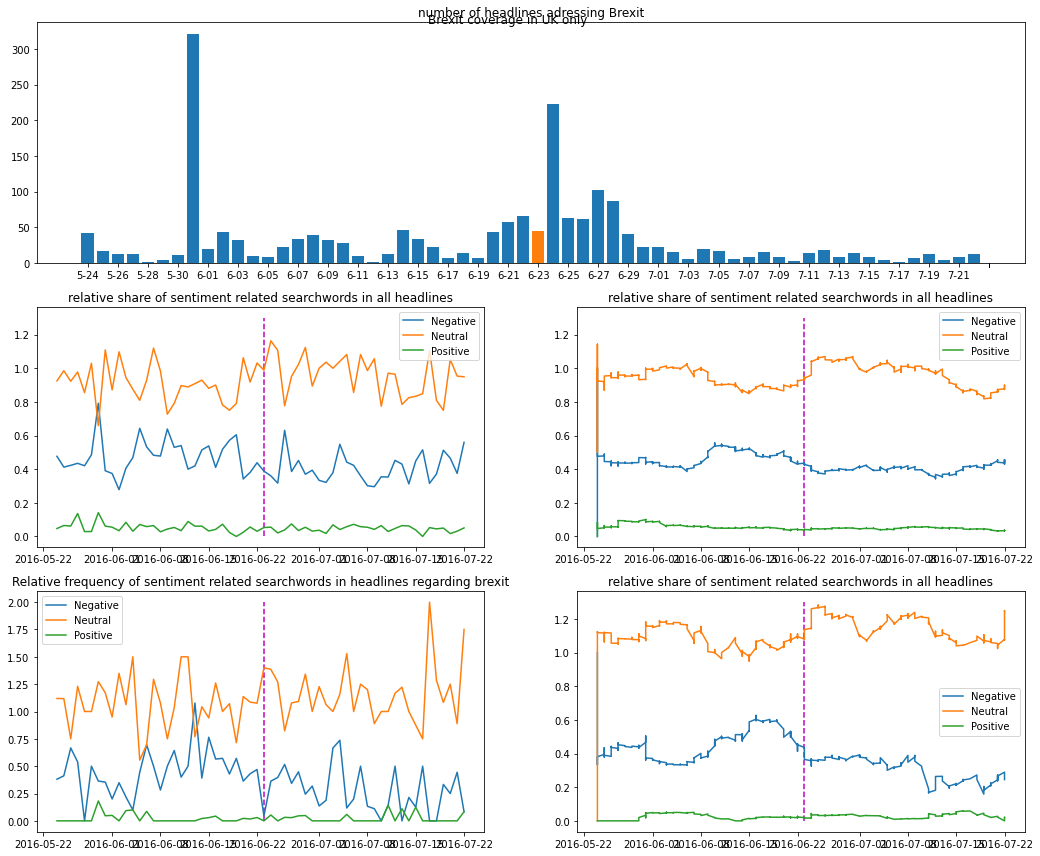

In [114]:

f,ax = plt.subplots(3,2,figsize=(15,12))

f.suptitle('Brexit coverage in UK only')
ax = plt.subplot(3,2,(1,2))
ticks = [str(d)[6:10] for d in (sentiment_UK.resample('d').size()).index]
ax = plt.bar(ticks,sentiment_UK.resample('d').size())
ax = plt.bar('6-23',sentiment_UK[sentiment_UK.index == '2016-06-23'].resample('d').size())
ax = plt.xticks([t if i%2==0 else ' 'for i,t in enumerate(ticks)])
plt.title('number of headlines adressing Brexit')


ax = plt.subplot(3,2,3)
ax = plt.plot(pd.concat([UKbrexit.resample('d').sum()[col]/UKbrexit.resample('d').size() for col in ['neg','neu','pos']],axis=1))
ax = plt.vlines(dt.datetime(2016, 6, 23),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')


ax = plt.subplot(3,2,4)
ax = plt.plot(UKbrexit.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2016, 6, 23),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')

ax = plt.subplot(3,2,5)

ax = plt.plot(pd.concat([sentiment_UK.resample('d').sum()[col]/sentiment_UK.resample('d').size() for col in ['neg','neu','pos']],axis=1))
ax = plt.vlines(dt.datetime(2016, 6, 23),0,2, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('Relative frequency of sentiment related searchwords in headlines regarding brexit')


ax = plt.subplot(3,2,6)
ax = plt.plot(sentiment_UK.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2016, 6, 23),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')

plt.tight_layout()

Within the headlines of the UK based publications we can see even clearer the reduction in amount of usage of negative words after the refferendum has taken place.<br>




## 2016 Presedential Election

out of 8249 headlines in the 2 month surrounding the event, 2453 dirrectly mentioned it (29.74).
at the day of the event itself out of 148 headlines,52 directly mentioned it.
715 headlines contain negetive words, 149 contain positive words, and 1803 contain neutral words
16 contains both positive and negitive words
example of a headline that contain both positive and negative headlines:
'terrific guy, fantastic country': trump's surprise praise for pakistan's. leader; pakistan's government has released details of an extraordinary telephone call between the us president-elect and pakistan's prime minister nawaz sharif 


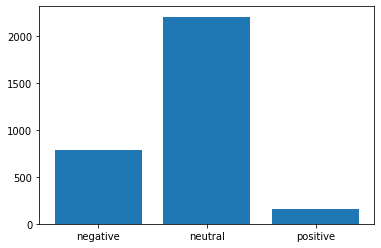

In [115]:
keywords = ['election','trump','clinton','electoral']

related = find_related(trump,'cleaned_text',keywords)                    
sentiment = calc_sent(trump,related,['cleaned_text','stemmed_searchwords','neg','neu','pos'])
tot, neg, pos, neu = related.sum(), (sentiment['neg']>0).sum() ,(sentiment['pos']>0).sum() ,(sentiment['neu']>0).sum()
both = ((sentiment['pos']>0) & (sentiment['neg']>0)).sum()


related_UK = find_related(UKtrump,'cleaned_text',keywords)                    
sentiment_UK = calc_sent(UKtrump,related_UK,['cleaned_text','stemmed_searchwords','neg','neu','pos'])

related_US = find_related(UStrump,'cleaned_text',keywords)                    
sentiment_US = calc_sent(UStrump,related_US,['cleaned_text','stemmed_searchwords','neg','neu','pos'])

print(f'out of {len(trump)} headlines in the 2 month surrounding the event, {len(trump[related])} dirrectly mentioned it ({np.round(100*len(trump[related])/len(trump),2)}).')
print(f'at the day of the event itself out of {len(trump[trump.index=="2016-11-08"])} headlines,{len(trump[related][trump[related].index=="2016-11-08"])} directly mentioned it.')
print(f'{neg} headlines contain negetive words, {pos} contain positive words, and {neu} contain neutral words\n{both} contains both positive and negitive words')

if both>0:
  print ('example of a headline that contain both positive and negative headlines:\n{}'.format(sentiment[(sentiment['pos']>0) & (sentiment['neg']>0)]['cleaned_text'].values[0]))
plt.bar(['negative','neutral','positive'],sentiment.iloc[:,2:].sum());

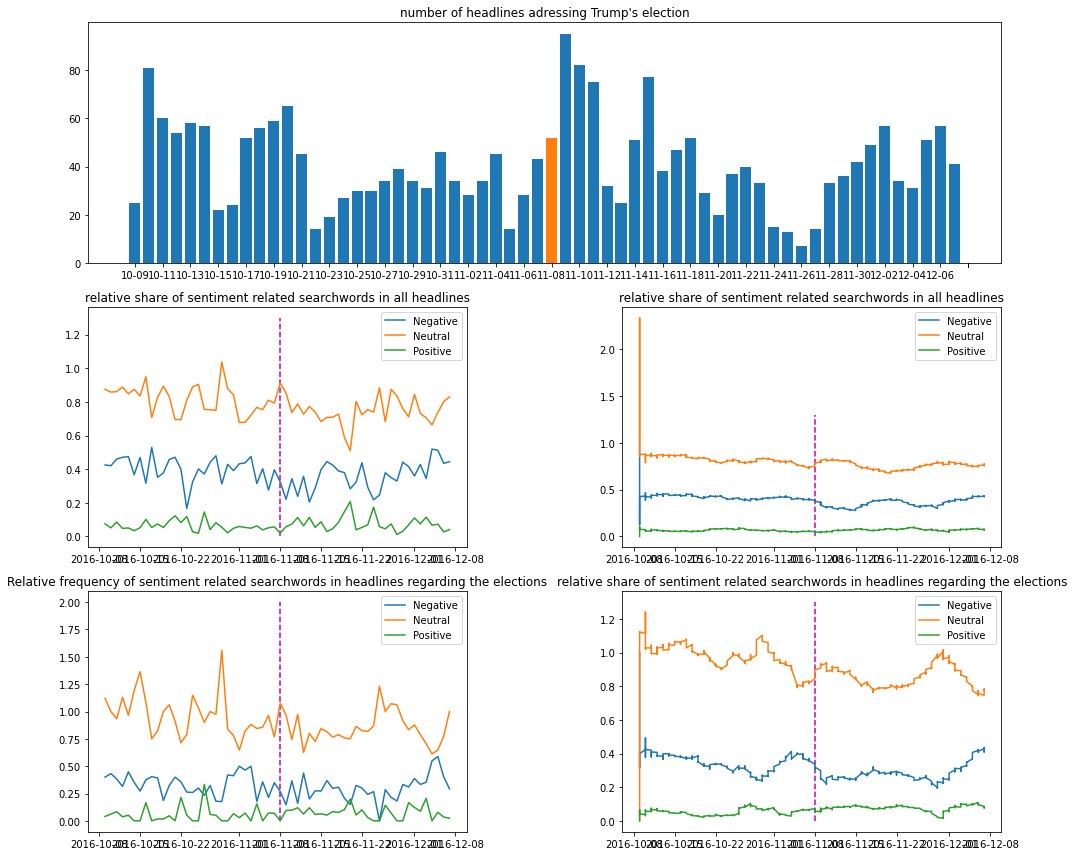

In [116]:
f,ax = plt.subplots(3,2,figsize=(15,12))


ax = plt.subplot(3,2,(1,2))
ticks = [str(d)[5:10] for d in (sentiment.resample('d').size()).index]
ax = plt.bar(ticks,sentiment.resample('d').size())
ax = plt.bar('11-08',sentiment[sentiment.index == '2016-11-08'].resample('d').size())
ax = plt.xticks([t if i%2==0 else ' 'for i,t in enumerate(ticks)])
plt.title("number of headlines adressing Trump's election")


ax = plt.subplot(3,2,3)
ax = plt.plot(pd.concat([trump.resample('d').sum()[col]/trump.resample('d').size() for col in ['neg','neu','pos']],axis=1))
ax = plt.vlines(dt.datetime(2016, 11, 8),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')


ax = plt.subplot(3,2,4)
ax = plt.plot(trump.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2016, 11, 8),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')

ax = plt.subplot(3,2,5)

ax = plt.plot(pd.concat([sentiment.resample('d').sum()[col]/sentiment.resample('d').size() for col in ['neg','neu','pos']],axis=1))
ax = plt.vlines(dt.datetime(2016, 11, 8),0,2, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('Relative frequency of sentiment related searchwords in headlines regarding the elections')


ax = plt.subplot(3,2,6)
ax = plt.plot(sentiment.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2016, 11, 8),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in headlines regarding the elections')

plt.tight_layout()

In [117]:
print (f'while in the US the Elections was mentioned in {len(sentiment_US)}({np.round(100*len(sentiment_US)/len(UStrump),2)}%) headlines,\nin the UK newspapers, the US elections was mentoined in {len(sentiment_UK)}({np.round(100*len(sentiment_UK)/len(UStrump),2)}%) headlines in the same time peroid')

while in the US the Elections was mentioned in 1952(37.9%) headlines,
in the UK newspapers, the US elections was mentoined in 501(9.73%) headlines in the same time peroid


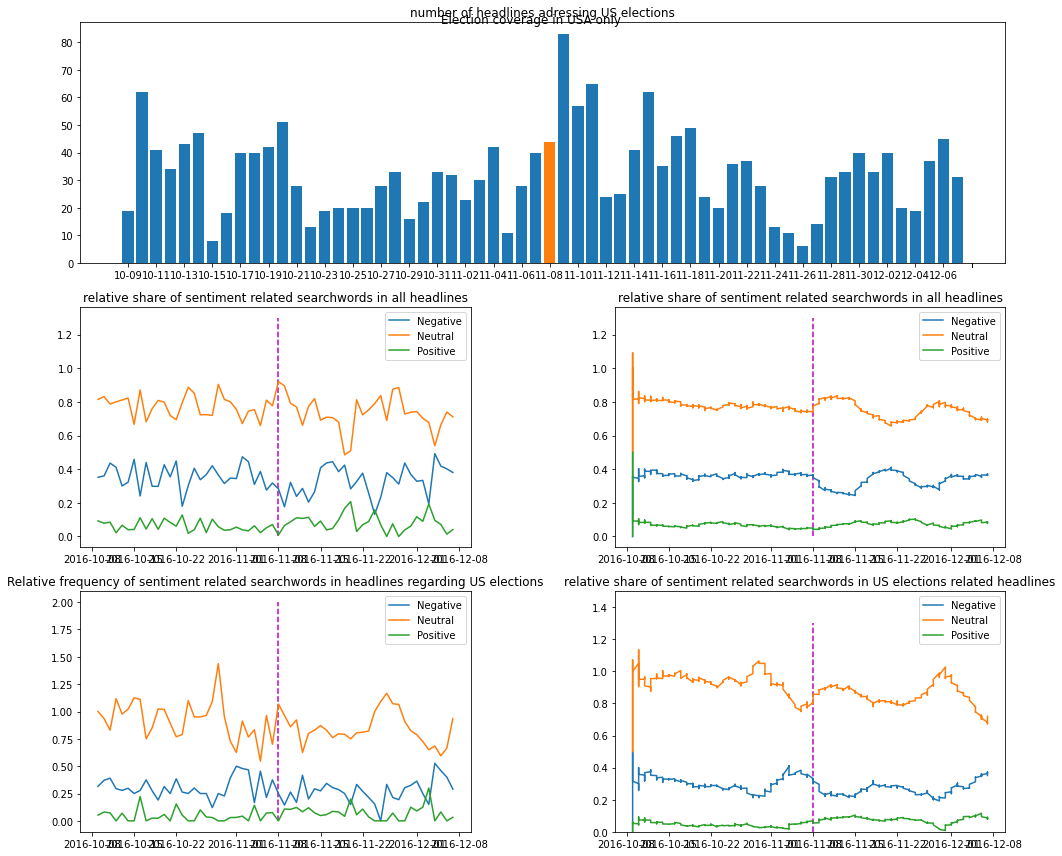

In [118]:

f,ax = plt.subplots(3,2,figsize=(15,12))

f.suptitle('Election coverage in USA only')
ax = plt.subplot(3,2,(1,2))
ticks = [str(d)[5:10] for d in (sentiment_US.resample('d').size()).index]
ax = plt.bar(ticks,sentiment_US.resample('d').size())
ax = plt.bar('11-08',sentiment_US[sentiment_US.index == '2016-11-08'].resample('d').size())
ax = plt.xticks([t if i%2==0 else ' 'for i,t in enumerate(ticks)])
plt.title('number of headlines adressing US elections')


ax = plt.subplot(3,2,3)
ax = plt.plot(pd.concat([UStrump.resample('d').sum()[col]/UStrump.resample('d').size() for col in ['neg','neu','pos']],axis=1))
ax = plt.vlines(dt.datetime(2016, 11, 8),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')


ax = plt.subplot(3,2,4)
ax = plt.plot(UStrump.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2016, 11, 8),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')

ax = plt.subplot(3,2,5)

ax = plt.plot(pd.concat([sentiment_US.resample('d').sum()[col]/sentiment_US.resample('d').size() for col in ['neg','neu','pos']],axis=1))
ax = plt.vlines(dt.datetime(2016, 11, 8),0,2, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('Relative frequency of sentiment related searchwords in headlines regarding US elections')


ax = plt.subplot(3,2,6)
ax = plt.plot(sentiment_US.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2016, 11, 8),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in US elections related headlines')
plt.ylim((0,1.5))

plt.tight_layout()

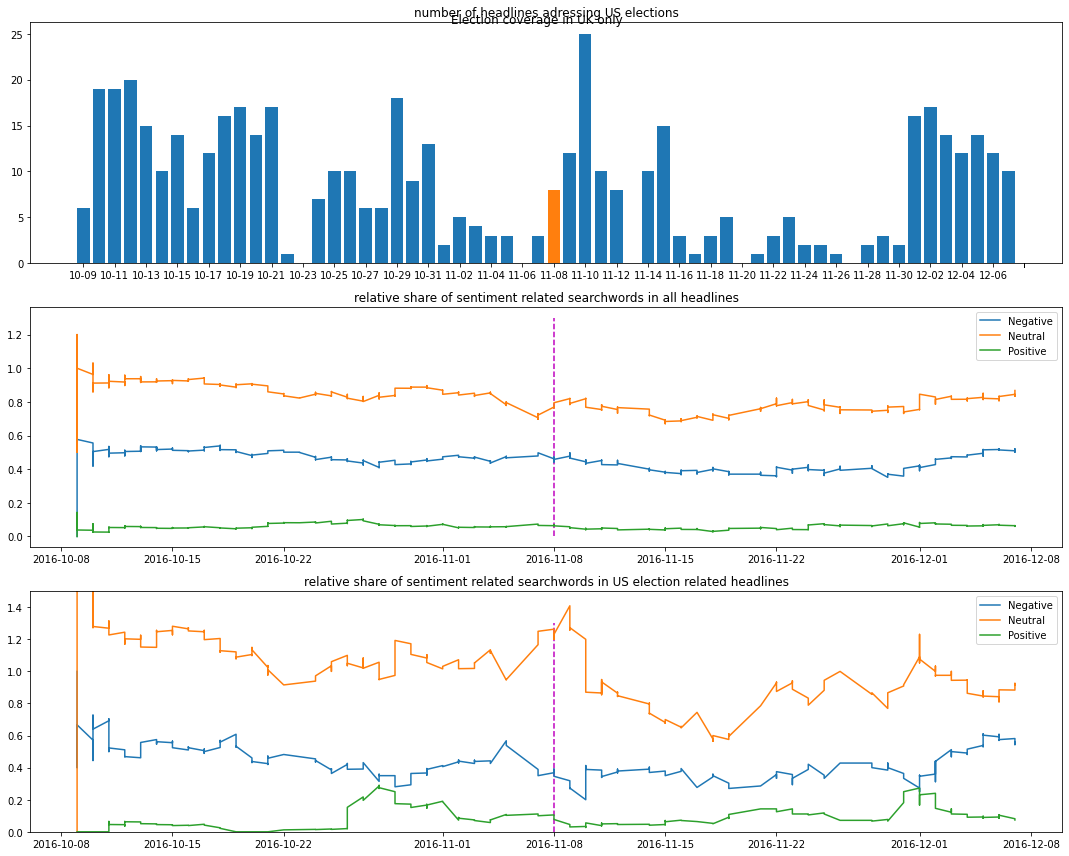

In [119]:

f,ax = plt.subplots(3,1,figsize=(15,12))

f.suptitle('Election coverage in UK only')
ax = plt.subplot(3,1,1)
ticks = [str(d)[5:10] for d in (sentiment_UK.resample('d').size()).index]
ax = plt.bar(ticks,sentiment_UK.resample('d').size())
ax = plt.bar('11-08',sentiment_UK[sentiment_UK.index == '2016-11-08'].resample('d').size())
ax = plt.xticks([t if i%2==0 else ' 'for i,t in enumerate(ticks)])
plt.title('number of headlines adressing US elections')





ax = plt.subplot(3,1,2)
ax = plt.plot(UKtrump.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2016, 11, 8),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')



ax = plt.subplot(3,1,3)
ax = plt.plot(sentiment_UK.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2016, 11, 8),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in US election related headlines')
plt.ylim((0,1.5))

plt.tight_layout()

## Paris Terror attacks

out of 7151 headlines in the month after the event, 578 dirrectly mentioned it (8.08).
at the day of the event itself out of 122 headlines,30 directly mentioned it.
222 headlines contain negetive words, 29 contain positive words, and 393 contain neutral words
1 contains both positive and negitive words
example of a headline that contain both positive and negative headlines:
anjem choudary back in custody for allegedly breaking bail conditions; radical preacher remanded in custody to await trial on charge of inviting support for banned terror group islamic state 


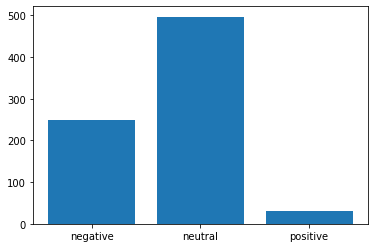

In [120]:
keywords = ['ןisis','terror','bomb','bataclan']

related = find_related(paris,'cleaned_text',keywords)                    
sentiment = calc_sent(paris,related,['cleaned_text','stemmed_searchwords','neg','neu','pos'])
tot, neg, pos, neu = related.sum(), (sentiment['neg']>0).sum() ,(sentiment['pos']>0).sum() ,(sentiment['neu']>0).sum()
both = ((sentiment['pos']>0) & (sentiment['neg']>0)).sum()


related_UK = find_related(parisUK,'cleaned_text',keywords)                    
sentiment_UK = calc_sent(parisUK,related_UK,['cleaned_text','stemmed_searchwords','neg','neu','pos'])

related_US = find_related(parisUSA,'cleaned_text',keywords)                    
sentiment_US = calc_sent(parisUSA,related_US,['cleaned_text','stemmed_searchwords','neg','neu','pos'])

print(f'out of {len(paris)} headlines in the month after the event, {len(paris[related])} dirrectly mentioned it ({np.round(100*len(paris[related])/len(paris),2)}).')
print(f'at the day of the event itself out of {len(paris[paris.index=="2015-11-14"])} headlines,{len(paris[related][paris[related].index=="2015-11-14"])} directly mentioned it.')
print(f'{neg} headlines contain negetive words, {pos} contain positive words, and {neu} contain neutral words\n{both} contains both positive and negitive words')

if both>0:
  print ('example of a headline that contain both positive and negative headlines:\n{}'.format(sentiment[(sentiment['pos']>0) & (sentiment['neg']>0)]['cleaned_text'].values[0]))
plt.bar(['negative','neutral','positive'],sentiment.iloc[:,2:].sum());

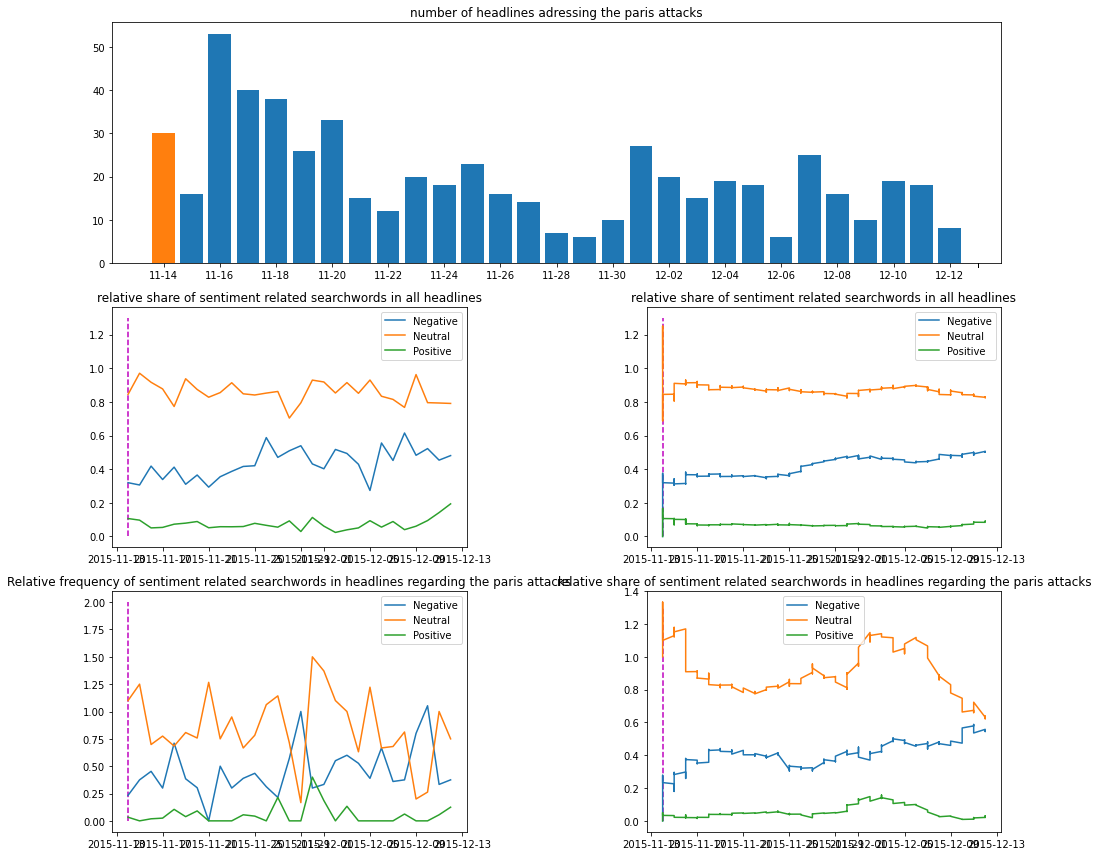

In [121]:
f,ax = plt.subplots(3,2,figsize=(15,12))


ax = plt.subplot(3,2,(1,2))
ticks = [str(d)[5:10] for d in (sentiment.resample('d').size()).index]
ax = plt.bar(ticks,sentiment.resample('d').size())
ax = plt.bar('11-14',sentiment[sentiment.index == '2015-11-14'].resample('d').size())
ax = plt.xticks([t if i%2==0 else ' 'for i,t in enumerate(ticks)])
plt.title("number of headlines adressing the paris attacks")


ax = plt.subplot(3,2,3)
ax = plt.plot(pd.concat([paris.resample('d').sum()[col]/paris.resample('d').size() for col in ['neg','neu','pos']],axis=1))
ax = plt.vlines(dt.datetime(2015, 11, 14),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')


ax = plt.subplot(3,2,4)
ax = plt.plot(paris.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2015, 11, 14),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')

ax = plt.subplot(3,2,5)

ax = plt.plot(pd.concat([sentiment.resample('d').sum()[col]/sentiment.resample('d').size() for col in ['neg','neu','pos']],axis=1))
ax = plt.vlines(dt.datetime(2015, 11, 14),0,2, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('Relative frequency of sentiment related searchwords in headlines regarding the paris attacks')


ax = plt.subplot(3,2,6)
ax = plt.plot(sentiment.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2015, 11, 14),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in headlines regarding the paris attacks')

plt.tight_layout()

In [122]:
print (f'while in the US the attacks were mentioned in {len(sentiment_US)}({np.round(100*len(sentiment_US)/len(parisUSA),2)}%) headlines,\nin the UK newspapers, the attacks were mentoined in {len(sentiment_UK)}({np.round(100*len(sentiment_UK)/len(parisUK),2)}%) headlines in the same time peroid')

while in the US the attacks were mentioned in 141(5.99%) headlines,
in the UK newspapers, the attacks were mentoined in 437(9.11%) headlines in the same time peroid


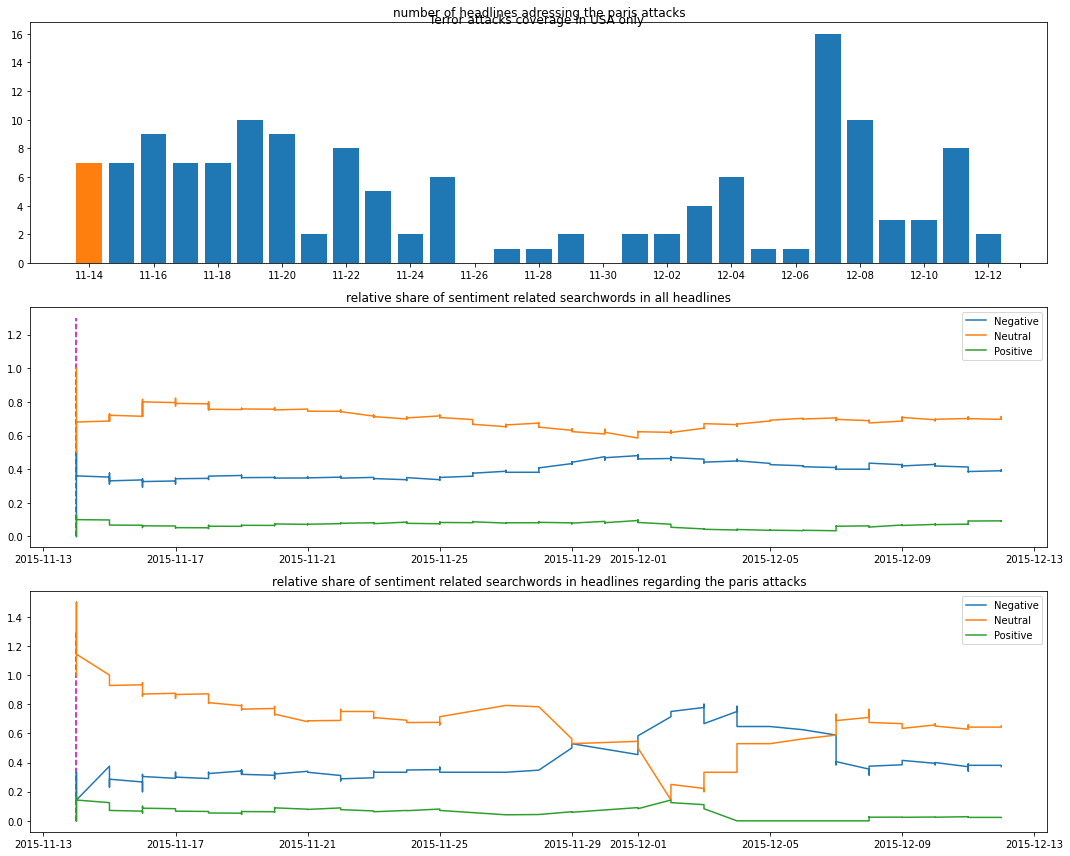

In [123]:

f,ax = plt.subplots(3,1,figsize=(15,12))

f.suptitle('Terror attacks coverage in USA only')


ax = plt.subplot(3,1,1)
ticks = [str(d)[5:10] for d in (sentiment_US.resample('d').size()).index]
ax = plt.bar(ticks,sentiment_US.resample('d').size())
ax = plt.bar('11-14',sentiment_US[sentiment_US.index == '2015-11-14'].resample('d').size())
ax = plt.xticks([t if i%2==0 else ' 'for i,t in enumerate(ticks)])
plt.title("number of headlines adressing the paris attacks")

ax = plt.subplot(3,1,2)
ax = plt.plot(parisUSA.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2015, 11, 14),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')

ax = plt.subplot(3,1,3)
ax = plt.plot(sentiment_US.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2015, 11, 14),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in headlines regarding the paris attacks')

plt.tight_layout()

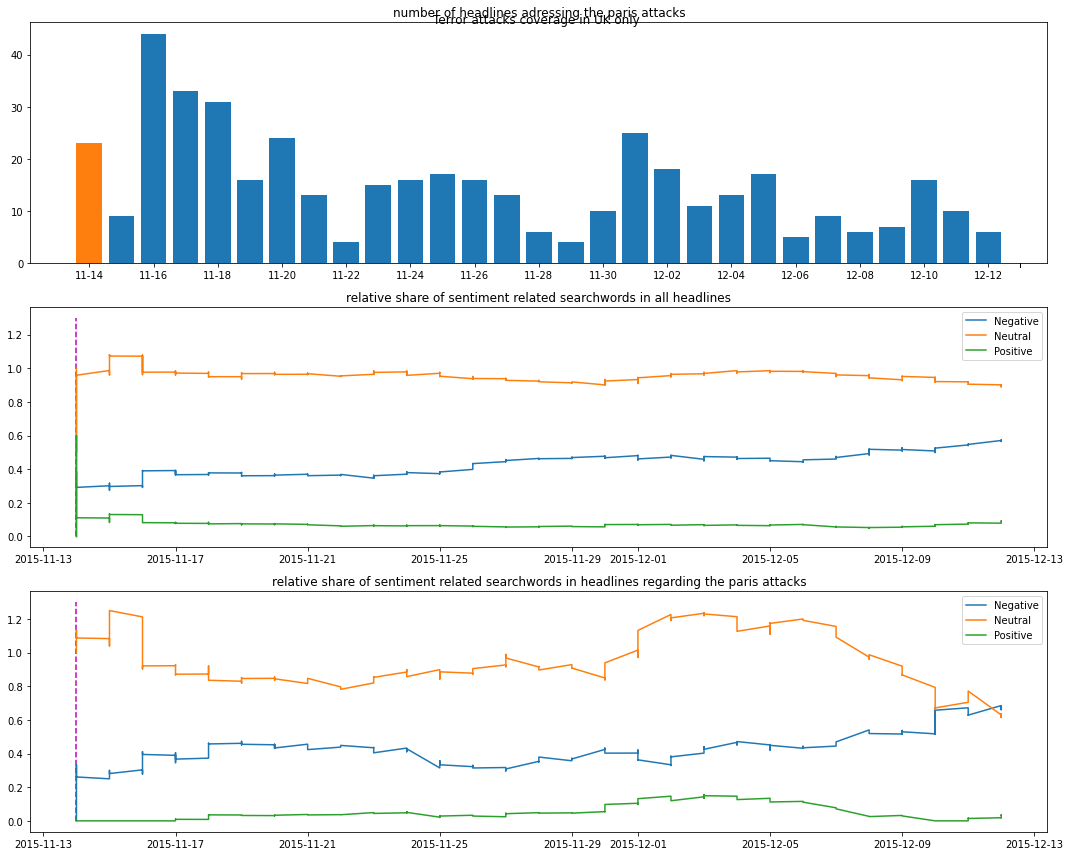

In [124]:

f,ax = plt.subplots(3,1,figsize=(15,12))

f.suptitle('Terror attacks coverage in UK only')


ax = plt.subplot(3,1,1)
ticks = [str(d)[5:10] for d in (sentiment_UK.resample('d').size()).index]
ax = plt.bar(ticks,sentiment_UK.resample('d').size())
ax = plt.bar('11-14',sentiment_UK[sentiment_UK.index == '2015-11-14'].resample('d').size())
ax = plt.xticks([t if i%2==0 else ' 'for i,t in enumerate(ticks)])
plt.title("number of headlines adressing the paris attacks")

ax = plt.subplot(3,1,2)
ax = plt.plot(parisUK.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2015, 11, 14),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in all headlines')

ax = plt.subplot(3,1,3)
ax = plt.plot(sentiment_UK.sort_index().rolling('7d').mean())
ax = plt.vlines(dt.datetime(2015, 11, 14),0,1.3, color = 'm', linestyle = '--')
ax = plt.legend(['Negative','Neutral','Positive'])
plt.title('relative share of sentiment related searchwords in headlines regarding the paris attacks')

plt.tight_layout()

# remarks\conclusions:
1. there is much less ambivalance regarding the fact that terror attacks are BAD, the event is much more dominant in the media, and although the amount of coverage decreases over time, there is much more resentment and negative words that are carried out to ALL headlines.
2. the most interesting thing to look upt for when examining the medias role in shaping the experience of an event is the amount of negitive words associated with it. since positive words are not very frequent anyway, and neutral words don't tell us much.
3. elections are polarizing. especially these 2 elections that were much thank to a negative campaign. 
4. it is unclear if the change in the amount of negative words is due to an affect that is related to the elections outcomes themselves, or due to less direct expressions that are part of the campign.